# 第二组与frquency spectrum不同的网络结构

## 模型训练

In [2]:
# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB  

import pywt
import numpy as np

import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend, regularizers
import time

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

TRAINDATA_LOADPATH = 'tool_wear_data_8/train_data.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = 'tool_wear_data_8/train_label.npy' #训练集标签读取路径
TESTDATA_LOADPATH = 'tool_wear_data_8/test_data.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  'tool_wear_data_8/test_label.npy' #验证集标签读取路径

SUMMARY_PATH = './logs'     #记录路径
# MODEL_SAVE_PATH = 'attention_distribution_dataset9/model.h5'
# MODEL_SAVE_PATH2 = 'attention_distribution_dataset9/model2.h5'
# MODEL_SAVE_PATH = 'attention_distribution_dataset10/model.h5'
# MODEL_SAVE_PATH2 = 'attention_distribution_dataset10/model2.h5'

MODEL_SAVE_PATH = 'mismatch_period_2/model.h5'
MODEL_SAVE_PATH2 = 'mismatch_period_2/model2.h5'

#信号层级关系
SIGNAL_LENGTH_1 = 2304
SIGNAL_LENGTH_2 = 36
SIGNAL_LENGTH_3 = 6

#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 7]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
SCALE_NUM_VIBRATION = 3 #小波分解级数
SCALE_NUM_AE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

LOWFREQ_INPUT_SIZE = [int(SIGNAL_LENGTH_1/8), 7]
LOWFREQ_LSTM_SIZE = 18
LOWFREQ_FEATURE_SIZE = 20
ATTENTION_SIZE = 23

HIGHFREQ_INPUT_SIZE = [SIGNAL_LENGTH_1, 6]
HIGHFREQ_LSTM_SIZE = 18
# LOWFREQ_FEATURE_SIZE = ATTENTION_SIZE
ATTENTION_RANGE = 64 #需要与splicing的个数对应
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
SAMPLING_STEP = LOWFREQ_INPUT_SIZE[0]/SIGNAL_LENGTH_2

LOCAL_INPUT_SIZE = [SIGNAL_LENGTH_2, LOWFREQ_FEATURE_SIZE+ATTENTION_SIZE]
LOCAL_TIMESTEP = int(SIGNAL_LENGTH_2/SIGNAL_LENGTH_3) #???
LOCAL_LSTM_SIZE = 25
LOCAL_DENSE_SIZE = 30

GLOBAL_INPUT_SIZE = [SIGNAL_LENGTH_3, LOCAL_DENSE_SIZE]
GLOBAL_LSTM_SIZE = 28
GLOBAL_DENSE_SIZE = 35

PREDICT_DENSE_SIZE = 200
OUTPUT_SIZE = 3

BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH1 = 7
PREDICTOR_TRAIN_BATCH2 = 4


##############################数据集读取########################################
X_train=np.load(TRAINDATA_LOADPATH)
Y_train=np.load(TRAINLABEL_LOADPATH)
X_test=np.load(TESTDATA_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train[:(np.shape(X_train)[0]-np.shape(X_train)[0]%BATCH_SIZE), :,:INPUT_NUM]
Y_train = Y_train[:(np.shape(Y_train)[0]-np.shape(Y_train)[0]%BATCH_SIZE), :OUTPUT_SIZE]
X_test = X_test[:(np.shape(X_test)[0]-np.shape(X_test)[0]%BATCH_SIZE), :,:INPUT_NUM]
Y_test = Y_test[:(np.shape(Y_test)[0]-np.shape(Y_test)[0]%BATCH_SIZE), :OUTPUT_SIZE]

############################################################小波分析##########################################################################################
#通过百分数滤除小尺度部分的噪声，输入小波信号整体
def percentile_compute(signal, percent): 
    percentile = np.percentile(np.abs(signal), percent)
    signal[np.abs(signal) < percentile] = 0
    return signal

def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

#         plt.figure(figsize=(30,2))
#         plt.plot(data[sample_index, :1024, j])
#         plt.show()
#         plt.figure(figsize=(30,2))
#         plt.plot(coeffs_lowfreq[sample_index, :128])
#         plt.show()
#         plt.figure(figsize=(30,2))
#         plt.plot(coeffs_highfreq[sample_index, :1024])
#         plt.show()
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

coeffs_train_force = wavelet_transform(X_train[:, :, 0:3], SCALE_NUM_FORCE)
coeffs_train_vibration = wavelet_transform(X_train[:, :, 3:6], SCALE_NUM_VIBRATION)
coeffs_train_AE = wavelet_transform(X_train[:, :, 6].reshape([np.shape(X_train)[0], np.shape(X_train)[1], 1]), SCALE_NUM_AE)
coeffs_train_AE = coeffs_train_AE[0]
coeffs_lowfreq_train = np.concatenate([coeffs_train_force[0], coeffs_train_vibration[0], coeffs_train_AE], axis = 2)#将不同尺度的小波系数降采样为同一长度
coeffs_highfreq_train = np.concatenate([coeffs_train_force[1], coeffs_train_vibration[1]], axis = 2)#将不同尺度的小波系数降采样为同一长度
print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train))
print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train))
print('Y_train', np.shape(Y_train))

coeffs_test_force = wavelet_transform(X_test[:, :, 0:3], SCALE_NUM_FORCE)
coeffs_test_vibration = wavelet_transform(X_test[:, :, 3:6], SCALE_NUM_VIBRATION)
coeffs_test_AE = wavelet_transform(X_test[:, :, 6].reshape([np.shape(X_test)[0], np.shape(X_test)[1], 1]), SCALE_NUM_AE)
coeffs_test_AE = coeffs_test_AE[0]
coeffs_lowfreq_test = np.concatenate([coeffs_test_force[0], coeffs_test_vibration[0], coeffs_test_AE], axis = 2)#将不同尺度的小波系数降采样为同一长度
coeffs_highfreq_test = np.concatenate([coeffs_test_force[1], coeffs_test_vibration[1]], axis = 2)#将不同尺度的小波系数降采样为同一长度
print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test))
print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test))
print('Y_test', np.shape(Y_test))

##############################################################################################频带模型搭建###############################################################
def lowfreq_model_construct(input_size, rnn_size, output_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='lowfreq_inputs')
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)
    x = layers.Lambda(lambda x: x[:, ::8])(x)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化,/8
    outputs = layers.TimeDistributed(layers.Dense(output_size))(x)
    outputs = layers.TimeDistributed(layers.LeakyReLU())(outputs)
    query = layers.TimeDistributed(layers.Dense(attention_size))(x)
    query = layers.TimeDistributed(layers.LeakyReLU())(query)
    query = layers.LayerNormalization(axis = 1)(query)
    model_lowfreq = models.Model(inputs=inputs, outputs=[outputs, query], name = name)
    return model_lowfreq

def highfreq_model_construct(input_size, rnn_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='highfreq_inputs')
#     x = layers.Lambda(adjust_range, name = 'adjust_range')(inputs)
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)#, recurrent_regularizer=regularizers.l1(0.000001)
    print('11', np.shape(x))
    key = layers.TimeDistributed(layers.Dense(attention_size))(x)
    key = layers.TimeDistributed(layers.LeakyReLU())(key)
    value = layers.TimeDistributed(layers.Dense(attention_size))(x)
    value = layers.TimeDistributed(layers.LeakyReLU())(value)
    key = layers.LayerNormalization(axis = 1)(key)
    value = layers.LayerNormalization(axis = 1)(value)
    model_highfreq = models.Model(inputs=inputs, outputs=[key, value], name = name)
    return model_highfreq

class lowhigh_freq_Attention(layers.Layer):
    def __init__(self, **kwargs):
        super(lowhigh_freq_Attention,self).__init__(**kwargs)
    def build(self, input_shape): 
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x): 
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
        scores = tf.matmul(query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value_weighted = tf.matmul(distribution, value)
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE)
    
class temporal_Attention(layers.Layer):
    def __init__(self, **kwargs): 
        super(temporal_Attention,self).__init__(**kwargs) 
    def build(self, input_shape): 
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        super(temporal_Attention,self).build(input_shape)
    def call(self, key): 
        scores = tf.matmul(self.u_query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])

#高低频时序特征提取
input_lowfreq = layers.Input(shape=LOWFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_lowfreq')
input_highfreq = layers.Input(shape=HIGHFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_highfreq')
model_lowfreq = lowfreq_model_construct(LOWFREQ_INPUT_SIZE, LOWFREQ_LSTM_SIZE, LOWFREQ_FEATURE_SIZE, ATTENTION_SIZE, 'lowfreq_model')
model_highfreq = highfreq_model_construct(HIGHFREQ_INPUT_SIZE, HIGHFREQ_LSTM_SIZE, ATTENTION_SIZE, 'highfreq_model')
# 低频特征构造query，高频特征构造key和value，构建低频特征向高频特征的注意力模型，使高低频长度一致并对齐
feature_lowfreq, query = model_lowfreq(input_lowfreq)
# feature_lowfreq = layers.Lambda(lambda x: x[:, ::6])(feature_lowfreq)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
# query = layers.Lambda(lambda x: x[:, ::6])(query)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
print('query', np.shape(query))
print('feature_lowfreq', np.shape(feature_lowfreq))
key, value = model_highfreq(input_highfreq)

#高低频注意力机制
query = layers.Reshape([-1, 1, ATTENTION_SIZE])(query)
print('query', np.shape(query))
value = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(value)
print('value', np.shape(value))
key = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(key)
print('key', np.shape(key))
concate_vector = layers.Concatenate(axis = 2)([query, value, key])
feature_highfreq, att_distribution_lowhigh = layers.TimeDistributed(lowhigh_freq_Attention())(concate_vector)
print('feature_highfreq', np.shape(feature_highfreq))
feature_freq = layers.Concatenate(axis = 2)([feature_lowfreq, feature_highfreq])

###############################################LSTM模型搭建###############################################################
def localLSTM_construct(input_size, timestep, lstm_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='input')
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.TimeDistributed(layers.LeakyReLU())(x)
    x = layers.Reshape([int(input_size[0]/timestep), timestep, dense_size])(x)
    x = layers.LayerNormalization(axis = 2)(x)
    outputs, att_distribution_local = layers.TimeDistributed(temporal_Attention())(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=[outputs, att_distribution_local], name = name)
    return biLSTM_model

biLSTM_local = localLSTM_construct(LOCAL_INPUT_SIZE, LOCAL_TIMESTEP, LOCAL_LSTM_SIZE, LOCAL_DENSE_SIZE, 'biLSTM_local')
feature_local, att_distribution_local = biLSTM_local(feature_freq)
print('feature_local', feature_local)

def globalLSTM_construct(input_size, lstm_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='input')
    x = layers.Bidirectional(layers.LSTM(lstm_size, return_sequences=False, name='biLSTM1'))(inputs)
    x = layers.Dense(dense_size)(x)
    outputs = layers.LeakyReLU()(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=outputs, name = name)
    return biLSTM_model

biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_LSTM_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
feature = biLSTM_global(feature_local)
print('feature', feature)
x = layers.Dense(PREDICT_DENSE_SIZE)(feature)
x = layers.LeakyReLU()(x)
# x = layers.Dropout(0.5)(x)
x = layers.Dense(OUTPUT_SIZE, name='output')(x)
output = layers.LeakyReLU()(x)
predictor = models.Model(inputs=[input_lowfreq, input_highfreq], outputs=output, name='tool_wear_predictor')
att_distribution_model = models.Model(inputs=[input_lowfreq, input_highfreq], 
                                      outputs=[att_distribution_lowhigh, att_distribution_local], 
                                      name = 'att_distribution_model')

predictor.summary()
#############################################模型训练#########################################################################
time_start = time.time()

adam = keras.optimizers.Adam(lr=0.008)
predictor.compile(optimizer=adam, loss = 'mse')

history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train], Y_train, batch_size=BATCH_SIZE, 
                        validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test], Y_test),
                        epochs=PREDICTOR_TRAIN_BATCH1,  shuffle=True, verbose=1)

adam = keras.optimizers.Adam(lr=0.001)
predictor.compile(optimizer=adam, loss = 'mse')
history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train], Y_train, batch_size=BATCH_SIZE, 
                        validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test], Y_test),
                        epochs=PREDICTOR_TRAIN_BATCH2,  shuffle=True, verbose=1)

predictor.save(MODEL_SAVE_PATH)
att_distribution_model.save(MODEL_SAVE_PATH2)
print('time1 =  ', time.time()-time_start)


coeffs_lowfreq_train (17088, 288, 7)
coeffs_highfreq_train (17088, 2304, 6)
Y_train (17088, 3)
coeffs_lowfreq_test (4224, 288, 7)
coeffs_highfreq_test (4224, 2304, 6)
Y_test (4224, 3)
11 (64, 2304, 36)
query (64, 36, 23)
feature_lowfreq (64, 36, 20)
query (64, 36, 1, 23)
value (64, 36, 64, 23)
key (64, 36, 64, 23)
feature_highfreq (64, 36, 23)
feature_local KerasTensor(type_spec=TensorSpec(shape=(64, 6, 30), dtype=tf.float32, name=None), name='biLSTM_local/time_distributed_11/transpose_1:0', description="created by layer 'biLSTM_local'")
feature KerasTensor(type_spec=TensorSpec(shape=(64, 35), dtype=tf.float32, name=None), name='biLSTM_global/leaky_re_lu_5/LeakyRelu:0', description="created by layer 'biLSTM_global'")
Model: "tool_wear_predictor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lowfreq (InputLayer)      [(64, 288, 7)]

## 结果显示

coeffs_lowfreq_train (17088, 288, 7)
coeffs_highfreq_train (17088, 2304, 6)
Y_train (17088, 3)
coeffs_lowfreq_test (4224, 288, 7)
coeffs_highfreq_test (4224, 2304, 6)
Y_test (4224, 3)
loss_train_avg 0.0013285988162009656
percent_train_avg 3.045828963574795 %
percent_train_avg[0] 3.387310164936487 %
percent_train_avg[1] 3.114879030523999 %
percent_train_avg[2] 2.635297695263898 %
loss_test_avg 0.00042014709888691065
percent_test_avg 2.219751261881843 %
percent_test_avg[0] 2.434381489705032 %
percent_test_avg[1] 2.3402471274000023 %
percent_test_avg[2] 1.884625168540494 %


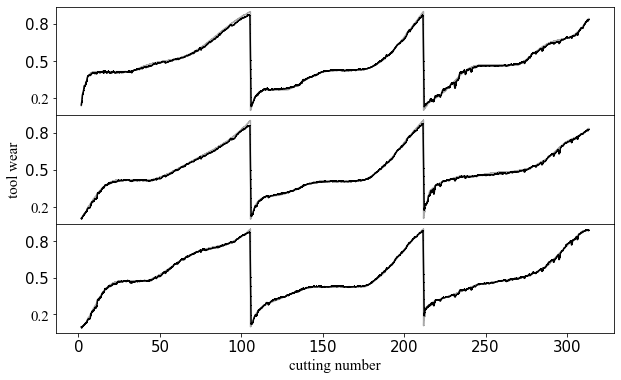

In [3]:
#
import numpy as np
import matplotlib.pyplot as plt
import pywt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend
import time

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off 
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

TRAINDATA_LOADPATH = 'tool_wear_data_8/train_data.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = 'tool_wear_data_8/train_label.npy' #训练集标签读取路径
TESTDATA_LOADPATH = 'tool_wear_data_8/test_data.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  'tool_wear_data_8/test_label.npy' #验证集标签读取路径

MODEL_LOAD_PATH = 'mismatch_period_2/model.h5'
MODEL_LOAD_PATH2 = 'mismatch_period_2/model2.h5'


load_flag = 1 ########################################1:重新加载模型，0：不加载##########################
#输入数据
INPUT_SIZE = [2304, 7]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
SCALE_NUM_VIBRATION = 3 #小波分解级数
SCALE_NUM_AE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

ATTENTION_RANGE = 64
OUTPUT_SIZE = 3
BATCH_SIZE = 64
size = 15

if load_flag == 1:
    class lowhigh_freq_Attention(layers.Layer):
        def __init__(self, **kwargs):
            super(lowhigh_freq_Attention,self).__init__(**kwargs)
        def build(self, input_shape):
            super(lowhigh_freq_Attention,self).build(input_shape)
        def call(self, x):
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
            value = x[:, 1:ATTENTION_RANGE+1]
            key = x[:, ATTENTION_RANGE+1:]
            scores = tf.matmul(query, key, transpose_b=True)
            distribution = tf.nn.softmax(scores, axis = 2)
            value_weighted = tf.matmul(distribution, value)
            value_weighted = tf.reduce_sum(value_weighted, axis=1)
            attention_distribution = tf.squeeze(distribution)
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE)

    class temporal_Attention(layers.Layer):
        def __init__(self, **kwargs): 
            super(temporal_Attention,self).__init__(**kwargs)
        def build(self, input_shape): 
            self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
            super(temporal_Attention,self).build(input_shape)
        def call(self, key): 
            scores = tf.matmul(self.u_query, key, transpose_b=True)
            distribution = tf.nn.softmax(scores, axis = 2)
            value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
            attention_distribution = tf.squeeze(distribution)
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])
        
    def wavelet_transform(data, scale_num):
        coeffs = np.arange(2).tolist()
        for j in range(np.shape(data)[2]):
            sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
            coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
            coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
            coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
            coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
    #         for i in range(1, scale_num+1):       #高频去噪
    #             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
            coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

    #         plt.figure(figsize=(30,2))
    #         plt.plot(data[sample_index, :1024, j])
    #         plt.show()
    #         plt.figure(figsize=(30,2))
    #         plt.plot(coeffs_lowfreq[sample_index, :128])
    #         plt.show()
    #         plt.figure(figsize=(30,2))
    #         plt.plot(coeffs_highfreq[sample_index, :1024])
    #         plt.show()

            if j == 0:
                coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
                coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
            else:
                coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
                coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
        return coeffs

    ################################################### 数据集读取及处理 ##################################################
    #train
    X_train=np.load(TRAINDATA_LOADPATH)
    Y_train=np.load(TRAINLABEL_LOADPATH)
    X_train = X_train[:(np.shape(X_train)[0]-np.shape(X_train)[0]%BATCH_SIZE),:, :INPUT_NUM]
    Y_train = Y_train[:(np.shape(Y_train)[0]-np.shape(Y_train)[0]%BATCH_SIZE), :OUTPUT_SIZE]

    coeffs_train_force = wavelet_transform(X_train[:, :, 0:3], SCALE_NUM_FORCE)
    coeffs_train_vibration = wavelet_transform(X_train[:, :, 3:6], SCALE_NUM_VIBRATION)
    coeffs_train_AE = wavelet_transform(X_train[:, :, 6].reshape([np.shape(X_train)[0], np.shape(X_train)[1], 1]), SCALE_NUM_AE)
    coeffs_train_AE = coeffs_train_AE[0]
    coeffs_lowfreq_train = np.concatenate([coeffs_train_force[0], coeffs_train_vibration[0], coeffs_train_AE], axis = 2)#将不同尺度的小波系数降采样为同一长度
    coeffs_highfreq_train = np.concatenate([coeffs_train_force[1], coeffs_train_vibration[1]], axis = 2)#将不同尺度的小波系数降采样为同一长度
    print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train))
    print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train))
    print('Y_train', np.shape(Y_train))
    
    #test
    X_test=np.load(TESTDATA_LOADPATH)
    Y_test=np.load(TESTLABEL_LOADPATH)
    X_test = X_test[:(np.shape(X_test)[0]-np.shape(X_test)[0]%BATCH_SIZE),:, :INPUT_NUM]
    Y_test = Y_test[:(np.shape(Y_test)[0]-np.shape(Y_test)[0]%BATCH_SIZE), :OUTPUT_SIZE]

    coeffs_test_force = wavelet_transform(X_test[:, :, 0:3], SCALE_NUM_FORCE)
    coeffs_test_vibration = wavelet_transform(X_test[:, :, 3:6], SCALE_NUM_VIBRATION)
    coeffs_test_AE = wavelet_transform(X_test[:, :, 6].reshape([np.shape(X_test)[0], np.shape(X_test)[1], 1]), SCALE_NUM_AE)
    coeffs_test_AE = coeffs_test_AE[0]
    coeffs_lowfreq_test = np.concatenate([coeffs_test_force[0], coeffs_test_vibration[0], coeffs_test_AE], axis = 2)#将不同尺度的小波系数降采样为同一长度
    coeffs_highfreq_test = np.concatenate([coeffs_test_force[1], coeffs_test_vibration[1]], axis = 2)#将不同尺度的小波系数降采样为同一长度
    print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test))
    print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test))
    print('Y_test', np.shape(Y_test))

    ################################################### 模型读取及预测 ##################################################
    predictor = keras.models.load_model(MODEL_LOAD_PATH, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                         'temporal_Attention':temporal_Attention})
    att_distribution_model = keras.models.load_model(MODEL_LOAD_PATH2, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                                       'temporal_Attention':temporal_Attention})

################################################### 波形显示 ##################################################
fig_x = 10
fig_y = 6
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}

#train
score = predictor.evaluate([coeffs_lowfreq_train, coeffs_highfreq_train], Y_train, verbose=0, batch_size = BATCH_SIZE)
Y_pre_train = predictor.predict([coeffs_lowfreq_train, coeffs_highfreq_train], batch_size = BATCH_SIZE)

v = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
result = [np.convolve(Y_pre_train[:, 0], v, mode='same'), np.convolve(Y_pre_train[:, 1], v, mode='same'), 
          np.convolve(Y_pre_train[:, 2], v, mode='same')]
result = np.transpose(result)

axis = np.linspace(1, 314, np.shape(result)[0])
print('loss_train_avg', np.mean(np.square(result - Y_train)))
print('percent_train_avg', np.mean(np.abs(result - Y_train)/Y_train)*100, '%')
print('percent_train_avg[0]', np.mean(np.abs(result[:, 0] - Y_train[:, 0])/Y_train[:, 0])*100, '%')
print('percent_train_avg[1]', np.mean(np.abs(result[:, 1] - Y_train[:, 1])/Y_train[:, 1])*100, '%')
print('percent_train_avg[2]', np.mean(np.abs(result[:, 2] - Y_train[:, 2])/Y_train[:, 2])*100, '%')

#test
score = predictor.evaluate([coeffs_lowfreq_test, coeffs_highfreq_test], Y_test, verbose=0, batch_size = BATCH_SIZE)
Y_pre_test = predictor.predict([coeffs_lowfreq_test, coeffs_highfreq_test], batch_size = BATCH_SIZE)

v = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
result = [np.convolve(Y_pre_test[:, 0], v, mode='same'), np.convolve(Y_pre_test[:, 1], v, mode='same'), 
          np.convolve(Y_pre_test[:, 2], v, mode='same')]
result = np.transpose(result)

axis = np.linspace(1, 314, np.shape(result)[0])
print('loss_test_avg', np.mean(np.square(result - Y_test)))
print('percent_test_avg', np.mean(np.abs(result - Y_test)/Y_test)*100, '%')
print('percent_test_avg[0]', np.mean(np.abs(result[:, 0] - Y_test[:, 0])/Y_test[:, 0])*100, '%')
print('percent_test_avg[1]', np.mean(np.abs(result[:, 1] - Y_test[:, 1])/Y_test[:, 1])*100, '%')
print('percent_test_avg[2]', np.mean(np.abs(result[:, 2] - Y_test[:, 2])/Y_test[:, 2])*100, '%')
        
for i in range(3):
    plt.subplot(3,1,i+1)
#     fig.xaxis.set_major_locator(ticker.MultipleLocator(3))
    if i == 0:
        plt.plot(axis[10:-10], Y_test[10:-10, i],'darkgrey',marker = ',',label = 'actual tool wear')
        plt.plot(axis[10:-10], result[10:-10, i],color = 'k', marker = ',', label = 'predicted result')
#         plt.legend(loc= 2, prop = font1)
        plt.xticks([])
    if i == 1:
        plt.plot(axis[10:-10], Y_test[10:-10, i],'darkgrey',marker = ',')
        plt.plot(axis[10:-10], result[10:-10, i],color = 'k', marker = ',')
        plt.xticks([])
        plt.ylabel('tool wear', fontproperties = 'Times New Roman', size = size)
    if i == 2:
        plt.plot(axis[10:-10], Y_test[10:-10, i],'darkgrey',marker = ',')
        plt.plot(axis[10:-10], result[10:-10, i],color = 'k', marker = ',')
        plt.xticks(fontproperties = 'Times New Roman', size = size)
#         plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = 20)
    plt.yticks([0.2, 0.5, 0.8], fontproperties = 'Times New Roman', size = size)

    
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.savefig('test_output.png', dpi = 300)
plt.show()

## 注意力权重存储及分布

att_distribution_value_local (4224, 36)
att_distribution_value_lowhigh (4224, 2304)
att_distribution_value_detail (4224, 2304)


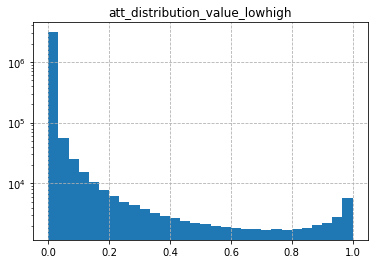

[9.44163313e-01 1.75251046e-02 7.66176166e-03 4.68306108e-03
 3.19571447e-03 2.38869407e-03 1.92877259e-03 1.53574317e-03
 1.35602855e-03 1.15134499e-03 9.99373619e-04 8.86242799e-04
 8.23049834e-04 7.32730133e-04 6.95739130e-04 6.55357284e-04
 6.22681897e-04 5.99562520e-04 5.61030224e-04 5.59488932e-04
 5.42534722e-04 5.30820904e-04 5.47775114e-04 5.38219105e-04
 5.56714607e-04 5.67811908e-04 6.39019590e-04 7.00054747e-04
 8.54183929e-04 1.79807104e-03]


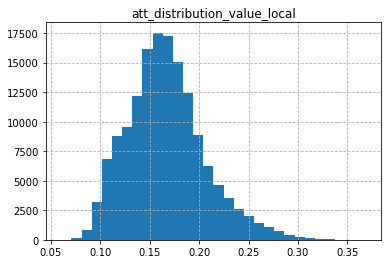

[1.31523569e-04 7.95717593e-04 5.34643308e-03 2.11095328e-02
 4.49613321e-02 5.80018939e-02 6.29011469e-02 8.02951389e-02
 1.06211858e-01 1.15280408e-01 1.13261521e-01 9.89386048e-02
 8.15314604e-02 5.83043981e-02 4.09235585e-02 3.06186869e-02
 2.30955387e-02 1.71769781e-02 1.30208333e-02 9.39735901e-03
 7.07596801e-03 4.83349116e-03 2.93955177e-03 1.59801136e-03
 1.05218855e-03 6.24736953e-04 3.74842172e-04 1.44675926e-04
 4.60332492e-05 6.57617845e-06]


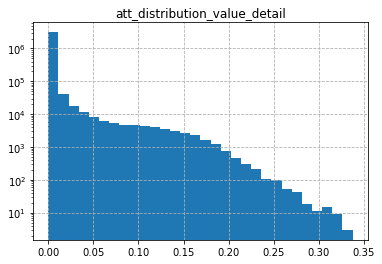

[9.61712462e-01 1.23651678e-02 5.66270616e-03 3.49410857e-03
 2.54744713e-03 1.96884618e-03 1.64332534e-03 1.48642184e-03
 1.41922151e-03 1.34246518e-03 1.24289773e-03 1.06379962e-03
 9.56525706e-04 8.48943537e-04 6.98205196e-04 5.09551077e-04
 3.93029415e-04 2.32118549e-04 1.43340140e-04 9.34022846e-05
 6.44259983e-05 3.36001618e-05 3.14423532e-05 1.60294350e-05
 1.32551097e-05 5.54865057e-06 3.39084201e-06 4.62387547e-06
 2.77432528e-06 9.24775095e-07]


In [4]:
#
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d
import pandas as pd
import seaborn as sns

ATT_LOCAL_SAVEPATH = 'mismatch_period_2/attention_local.npy'
ATT_LOWHIGH_SAVEPATH = 'mismatch_period_2/attention_lowhigh.npy'
ATT_DETAIL_SAVEPATH = 'mismatch_period_2/attention_detail.npy'

att_distribution_value_lowhigh, att_distribution_value_local = att_distribution_model.predict(
    [coeffs_lowfreq_test, coeffs_highfreq_test], batch_size = BATCH_SIZE)
att_distribution_value_local = att_distribution_value_local.reshape([np.shape(att_distribution_value_local)[0], -1])
np.save(ATT_LOCAL_SAVEPATH, att_distribution_value_local)#(1280, 48)
np.save(ATT_LOWHIGH_SAVEPATH, att_distribution_value_lowhigh.reshape([np.shape(att_distribution_value_lowhigh)[0], -1]))#(1280, 2304)

######################local_attention插值##########################################
att_distribution_value_local = np.expand_dims(att_distribution_value_local, axis=2)#(1280, 48, 1)
att_distribution_value_detail = att_distribution_value_lowhigh * att_distribution_value_local#(1280, 48, 48)
att_distribution_value_detail = att_distribution_value_detail.reshape(np.shape(att_distribution_value_detail)[0], -1)

np.save(ATT_DETAIL_SAVEPATH, att_distribution_value_detail)
att_distribution_value_local = att_distribution_value_local.reshape(np.shape(att_distribution_value_local)[0], -1)
att_distribution_value_lowhigh = att_distribution_value_lowhigh.reshape(np.shape(att_distribution_value_lowhigh)[0], -1)
print('att_distribution_value_local', np.shape(att_distribution_value_local))
print('att_distribution_value_lowhigh', np.shape(att_distribution_value_lowhigh))
print('att_distribution_value_detail', np.shape(att_distribution_value_detail))

##################################################################################

plt.title('att_distribution_value_lowhigh') 
a, b, c = plt.hist(att_distribution_value_lowhigh[::3].reshape([-1]), bins=30, density=False, log=True)
plt.grid(linestyle='--')
plt.show()
print(a/np.sum(a))

plt.title('att_distribution_value_local') 
a, b, c = plt.hist(att_distribution_value_local.reshape([-1]), bins=30, density=False, log=False)
plt.grid(linestyle='--')
plt.show()
print(a/np.sum(a))

plt.title('att_distribution_value_detail') 
a, b, c = plt.hist(att_distribution_value_detail[::3].reshape([-1]), bins=30, density=False, log=True)
plt.grid(linestyle='--')
plt.show()
print(a/np.sum(a))


## 注意力权重显示

X_test (4280, 2304, 7)
att_distribution_value_local (4224, 36)
att_distribution_value_lowhigh (4224, 2304)
att_distribution_value_detail (4224, 2304)
local attention, lowhigh attention, detail attention


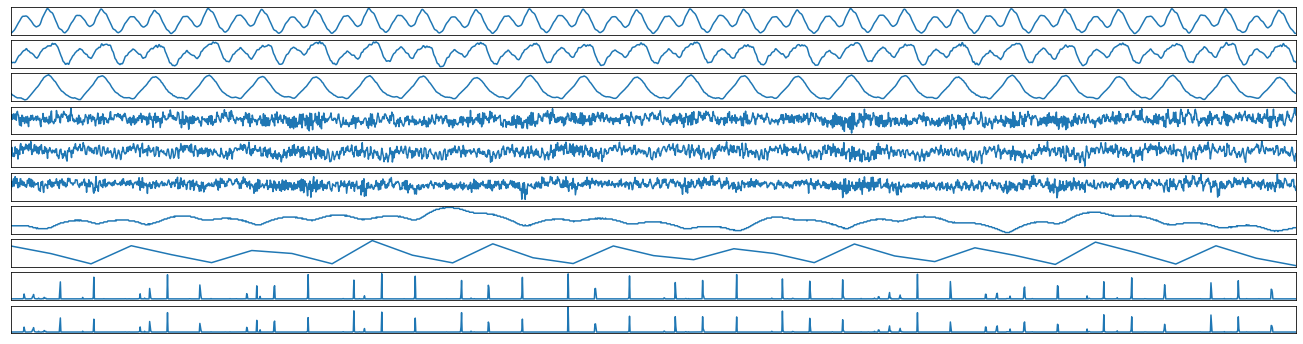

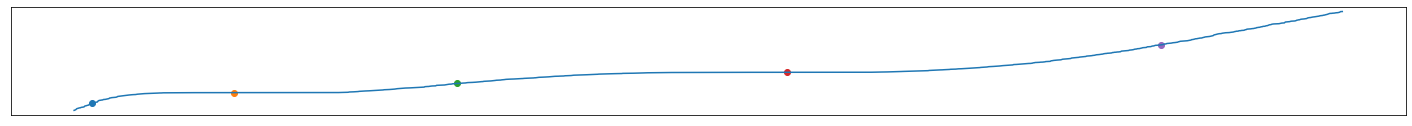

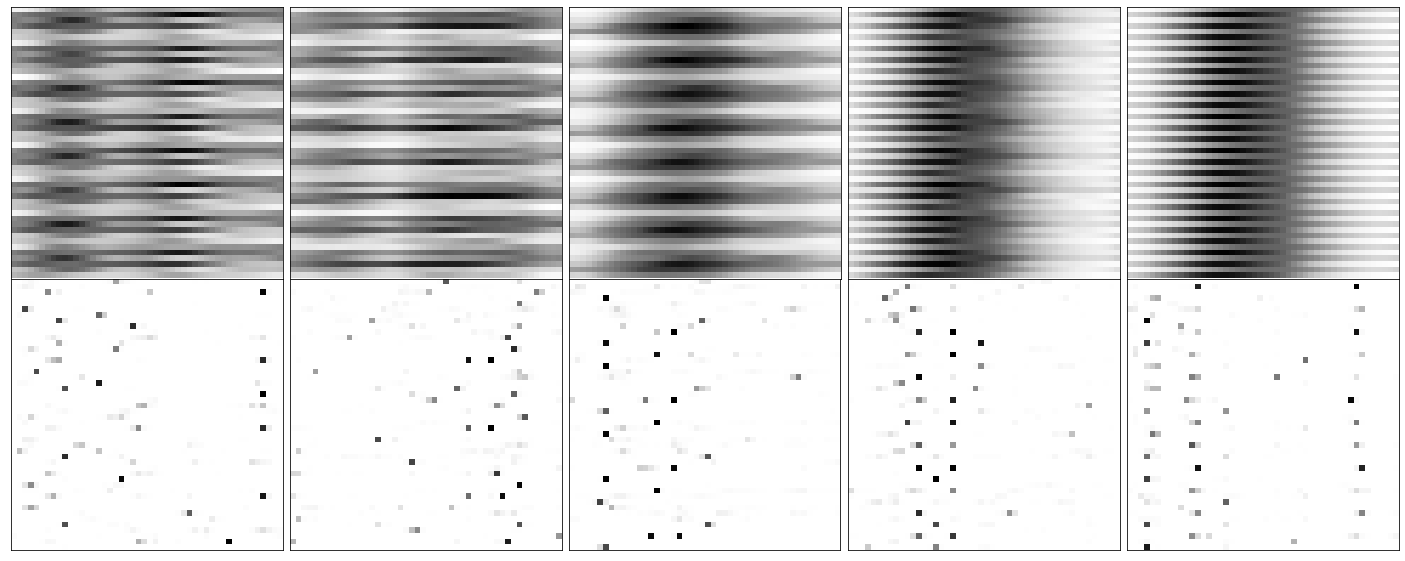

In [5]:
#注意力权重显示
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

HIGHFREQ_INPUT_SIZE = [2304, 6]
LOWFREQ_INPUT_SIZE = [288, 7]
ATTENTION_RANGE = 72

sample_index = 1000

ATT_LOCAL_LOADPATH = 'mismatch_period_2/attention_local.npy'
ATT_LOWHIGH_LOADPATH = 'mismatch_period_2/attention_lowhigh.npy'
ATT_DETAIL_LOADPATH = 'mismatch_period_2/attention_detail.npy'
TESTDATA_LOADPATH = 'tool_wear_data_8/test_data.npy'

HIGHFREQ_FORCE_SAVEPATH = 'mismatch_period_2/highfreq_force.png'
HIGHFREQ_VIBRATION_SAVEPATH = 'mismatch_period_2/highfreq_vibration.png'
LOWFREQ_FORCE_SAVEPATH = 'mismatch_period_2/lowfreq_force.png'
LOWFREQ_VIBRATION_SAVEPATH = 'mismatch_period_2/lowfreq_vibration.png'
ATT_LOWHIGH_SAVEPATH = 'mismatch_period_2/attention_lowhigh.png'
ATTENTION_SIGNAL_SAVEPATH = 'mismatch_period_2/attention_signal.png'
LABEL_SAVEPATH = 'mismatch_period_2/label.png'
ATTENTION_SIGNAL_SAVEPATH2 = 'mismatch_period_2/attention_signal2.png'

att_distribution_value_local = np.load(ATT_LOCAL_LOADPATH)
att_distribution_value_lowhigh = np.load(ATT_LOWHIGH_LOADPATH)
att_distribution_value_detail = np.load(ATT_DETAIL_LOADPATH)
X_test = np.load(TESTDATA_LOADPATH)

print('X_test', np.shape(X_test))
print('att_distribution_value_local', np.shape(att_distribution_value_local))
print('att_distribution_value_lowhigh', np.shape(att_distribution_value_lowhigh))
print('att_distribution_value_detail', np.shape(att_distribution_value_detail))

# local attention, lowhigh attention, detail attention
print('local attention, lowhigh attention, detail attention')
fig_x = 23.04
fig_y = 6
plt.figure(figsize=(fig_x, fig_y))
for i in range(7):
    plt.subplot(10, 1, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(xmin=0)
    plt.xlim(xmax=2304)
    plt.plot(X_test[sample_index, :, i])

plt.subplot(10, 1, 8)
plt.xticks([])
plt.yticks([])
plt.xlim(xmin=0)
plt.xlim(xmax=32)
plt.plot(att_distribution_value_local[sample_index])

plt.subplot(10, 1, 9)
plt.xticks([])
plt.yticks([])
plt.xlim(xmin=0)
plt.xlim(xmax=2304)
plt.plot(att_distribution_value_lowhigh[sample_index])#2304

plt.subplot(10, 1, 10)
plt.plot(att_distribution_value_detail[sample_index])#2304
plt.xticks([])
plt.yticks([])
plt.xlim(xmin=0)
plt.xlim(xmax=2304)
plt.savefig(ATT_LOWHIGH_SAVEPATH, dpi = 1000, bbox_inches='tight')
plt.show()




sample_list = [20, 180, 430, 800, 1220]
fig_x = 25
fig_y = 2
plt.figure(figsize=(fig_x, fig_y))
plt.plot(Y_test[1420:2845,0])

for i in sample_list:
    plt.scatter(i, Y_test[i+1420,0])
plt.xticks([])
plt.yticks([])
plt.savefig(LABEL_SAVEPATH, dpi = 300, bbox_inches='tight')
plt.show()

fig_x = 25
fig_y = 10
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
i = 0
for sample_index in sample_list:
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[sample_index+1420, :, 0].reshape([48,-1]), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(2, 5, i+6)
    plt.imshow(att_distribution_value_lowhigh[sample_index+1420].reshape([48,48]), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    i+=1
plt.savefig(ATTENTION_SIGNAL_SAVEPATH2, dpi = 300, bbox_inches='tight')
plt.show()

X_test (4280, 2304, 7)
Y_test (4280, 3)
att_distribution_value_local (4224, 36)
att_distribution_value_lowhigh (4224, 2304)
att_distribution_value_detail (4224, 2304)


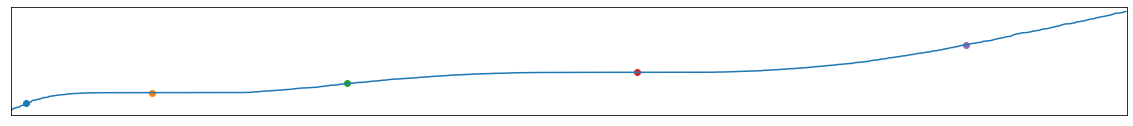

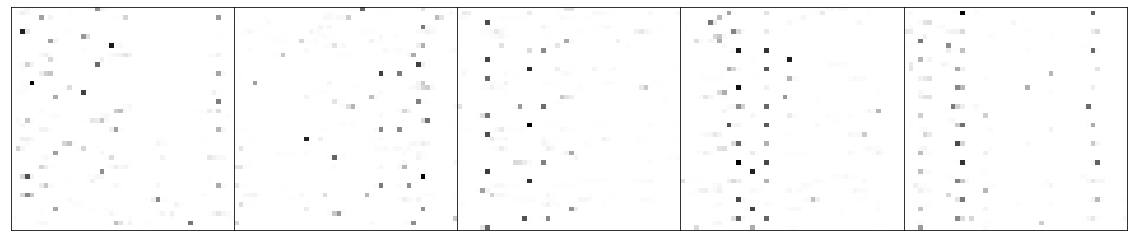

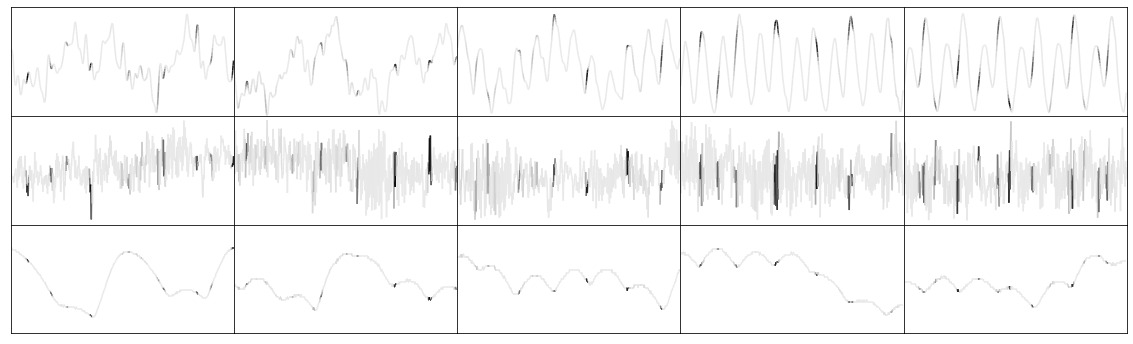

In [6]:
#注意力权重显示
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

HIGHFREQ_INPUT_SIZE = [2304, 6]
LOWFREQ_INPUT_SIZE = [288, 7]
ATTENTION_RANGE = 72
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
sample_index = 100

TESTDATA_LOADPATH = 'tool_wear_data_8/test_data.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  'tool_wear_data_8/test_label.npy' #验证集标签读取路径
ATT_LOCAL_LOADPATH = 'mismatch_period_2/attention_local.npy'
ATT_LOWHIGH_LOADPATH = 'mismatch_period_2/attention_lowhigh.npy'
ATT_DETAIL_LOADPATH = 'mismatch_period_2/attention_detail.npy'

HIGHFREQ_FORCE_SAVEPATH = 'mismatch_period_2/highfreq_force.png'
HIGHFREQ_VIBRATION_SAVEPATH = 'mismatch_period_2/highfreq_vibration.png'
LOWFREQ_FORCE_SAVEPATH = 'mismatch_period_2/lowfreq_force.png'
LOWFREQ_VIBRATION_SAVEPATH = 'mismatch_period_2/lowfreq_vibration.png'
ATT_LOWHIGH_SAVEPATH = 'mismatch_period_2/attention_lowhigh.png'
ATTENTION_SIGNAL_SAVEPATH = 'mismatch_period_2/attention_signal.png'
LABEL_SAVEPATH = 'mismatch_period_2/label.png'
ATTENTION_SIGNAL_SAVEPATH2 = 'mismatch_period_2/attention_signal2.png'

X_test = np.load(TESTDATA_LOADPATH)
Y_test = np.load(TESTLABEL_LOADPATH)
att_distribution_value_local = np.load(ATT_LOCAL_LOADPATH)
att_distribution_value_lowhigh = np.load(ATT_LOWHIGH_LOADPATH)
att_distribution_value_detail = np.load(ATT_DETAIL_LOADPATH)

print('X_test', np.shape(X_test))
print('Y_test', np.shape(Y_test))
print('att_distribution_value_local', np.shape(att_distribution_value_local))
print('att_distribution_value_lowhigh', np.shape(att_distribution_value_lowhigh))
print('att_distribution_value_detail', np.shape(att_distribution_value_detail))

sample_list = [20, 180, 430, 800, 1220]
start_list = [200, 200, 200, 200, 200]
fig_x = 20
fig_y = 2
plt.figure(figsize=(fig_x, fig_y))
plt.plot(Y_test[1420:2845,0])
for i in sample_list:
    plt.scatter(i, Y_test[i+1420,0])
plt.xlim(0, np.shape(Y_test[1420:2845,0])[0])
plt.xticks([])
plt.yticks([])
plt.savefig(LABEL_SAVEPATH, dpi = 300, bbox_inches='tight')
plt.show()

i = 0
fig_x = 20
fig_y = 10
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
for sample_index in sample_list:
    plt.subplot(1, 5, i+1)
    plt.imshow(att_distribution_value_detail[sample_index+1420].reshape([48,48]), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    i+=1
plt.savefig(ATTENTION_SIGNAL_SAVEPATH, dpi = 300, bbox_inches='tight')
plt.show()


def gaussian_filtering(input_x, variation = 2, filter_length = 20):   #一维高斯滤波，输入方差、滤波器长度和输入
    filter_x = np.array(np.arange(-filter_length/2, filter_length/2))
    gauss_filter = np.exp(-pow(filter_x, 2)/(2*pow(variation, 2)))/(variation*np.sqrt(2*np.pi))
    gauss_filter = gauss_filter/np.sum(gauss_filter)
#     plt.plot(gauss_filter)
#     plt.show()
    filted_signal = np.convolve(input_x, gauss_filter, mode='same')
    return filted_signal

fig_index = 0
fig_x = 4
fig_y = 2
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 6))
fig.subplots_adjust(wspace=0, hspace=0)
axs = axs.flatten()
for i in range(np.shape(sample_list)[0]):
    X_sample = X_test[sample_list[i]+1420, start_list[i]:start_list[i]+int(np.shape(X_test)[1]/4), :]
    A_sample = att_distribution_value_detail[sample_list[i]+1420, start_list[i]:start_list[i]+int(np.shape(X_test)[1]/4)]
    A_sample = gaussian_filtering(A_sample)
    A_sample = (A_sample - np.min(A_sample))/(np.max(A_sample)-np.min(A_sample)) # 灰度值归一化到[0.3, 1]
    A_sample[0] = -0.2
    
    col_index = 0
    for j in [0, 3, 6]:
        points = np.transpose([np.arange(np.shape(X_sample)[0]), X_sample[:, j]]).reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        axs[i+5*col_index].set_xticks([])
        axs[i+5*col_index].set_yticks([])
        lc = LineCollection(segments, cmap='Greys')
        lc.set_array(A_sample)
        line = axs[i+5*col_index].add_collection(lc)
        axs[i+5*col_index].set_xlim(0, np.shape(X_sample)[0])
        axs[i+5*col_index].set_ylim(X_sample[:, j].min() - 0.1*np.abs(X_sample[:, j].min()), X_sample[:, j].max() + 0.1*np.abs(X_sample[:, j].max()))
        
        col_index+=1
plt.savefig(ATTENTION_SIGNAL_SAVEPATH2, dpi = 300, bbox_inches='tight')
plt.show()


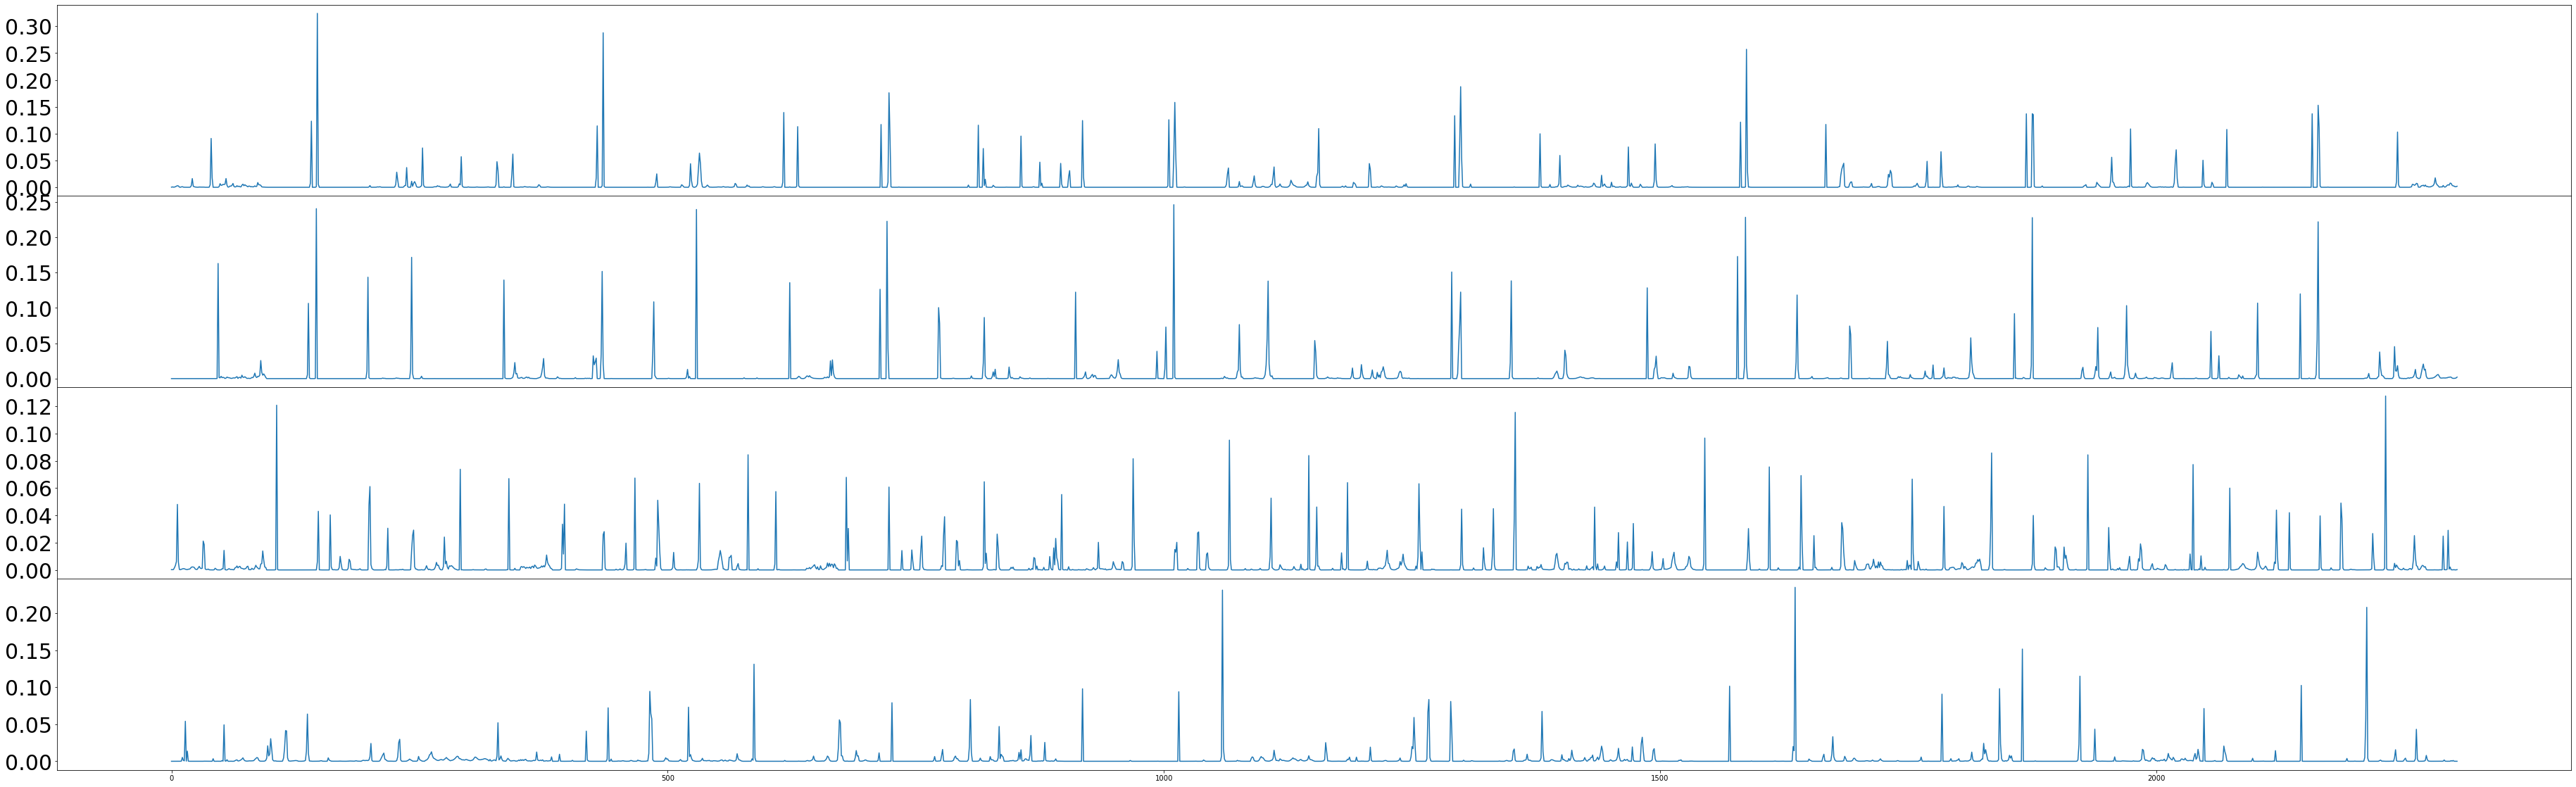

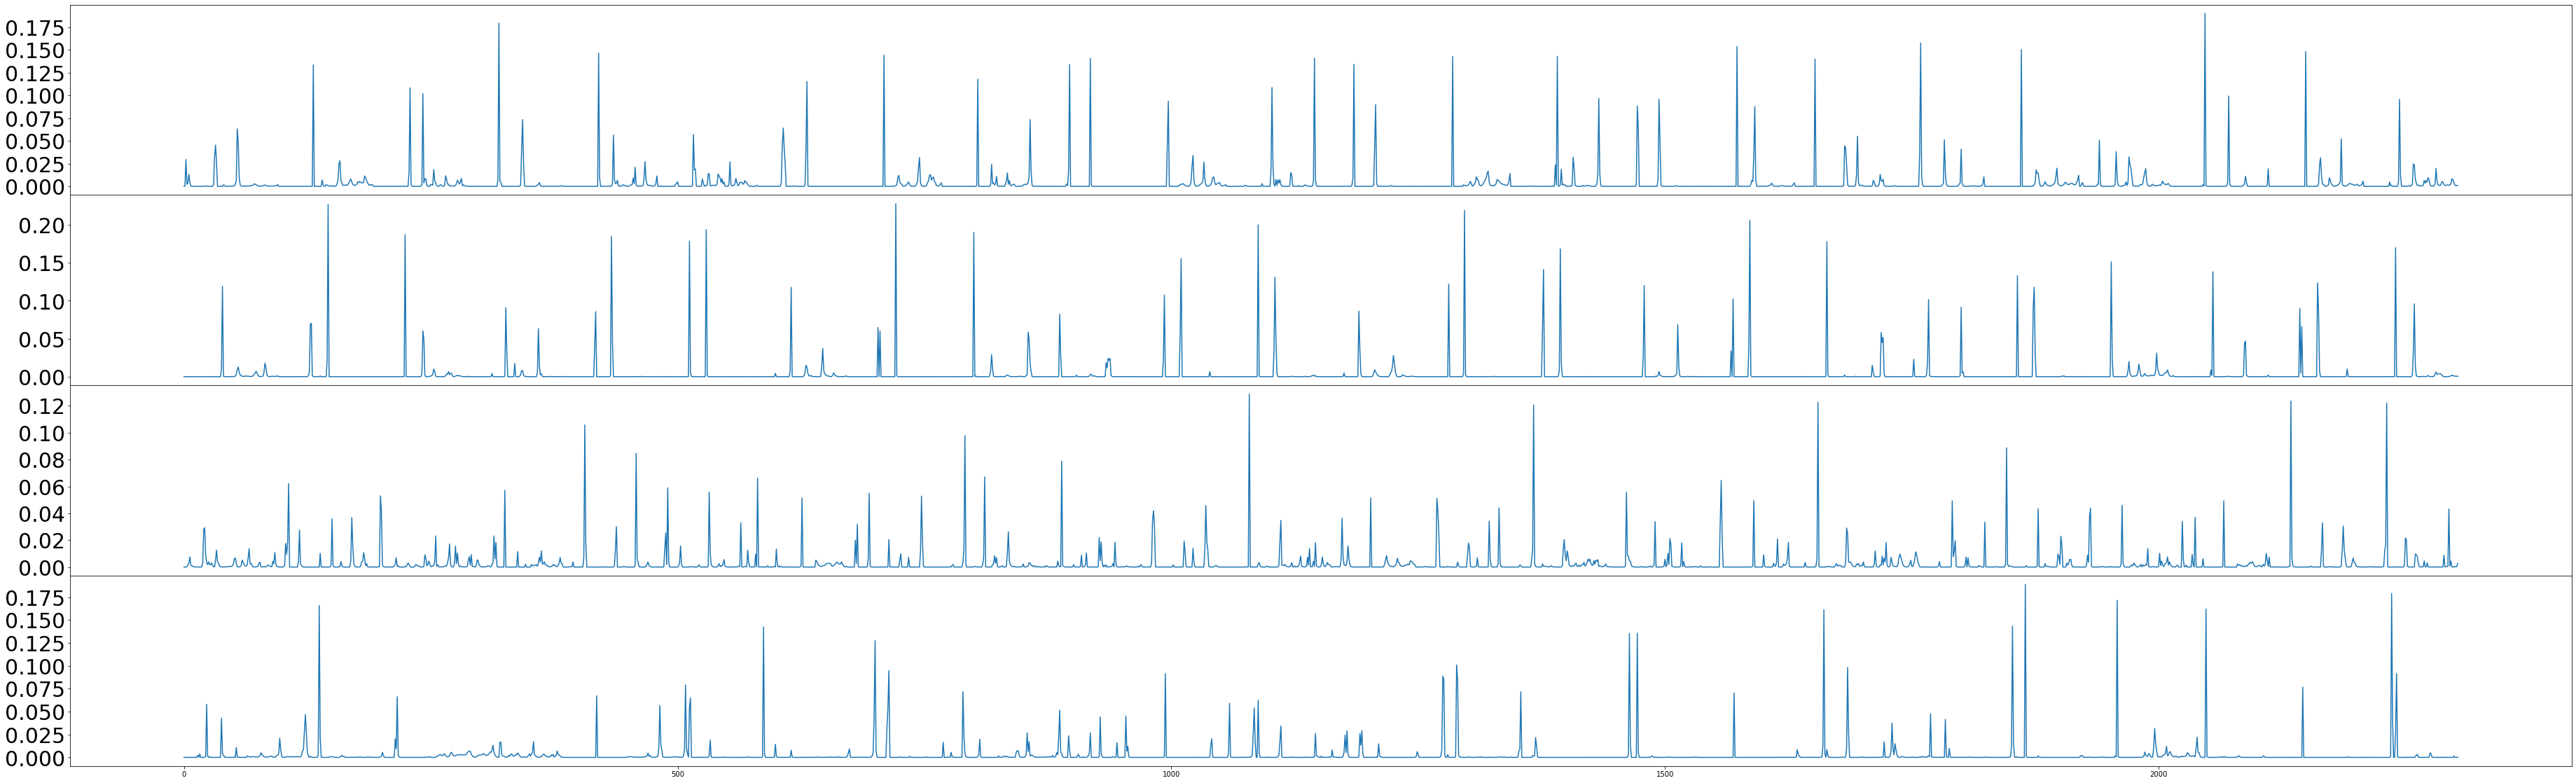

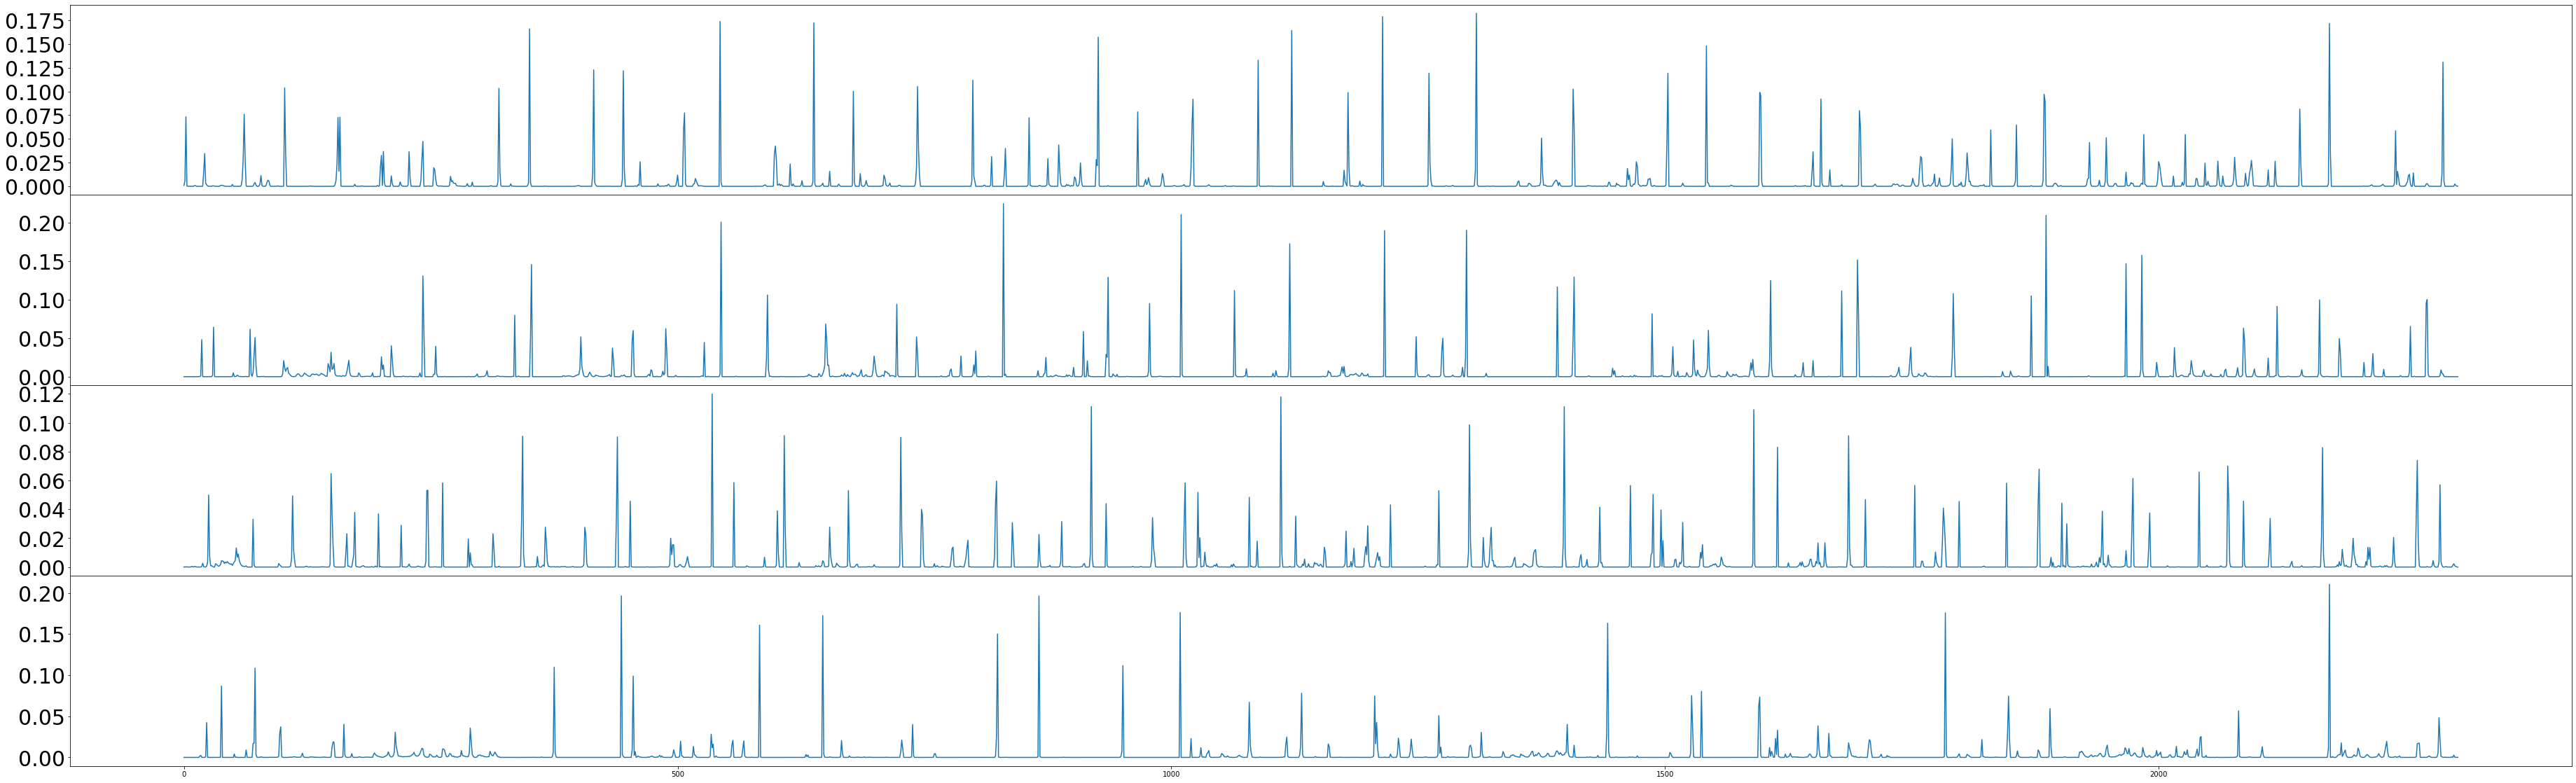

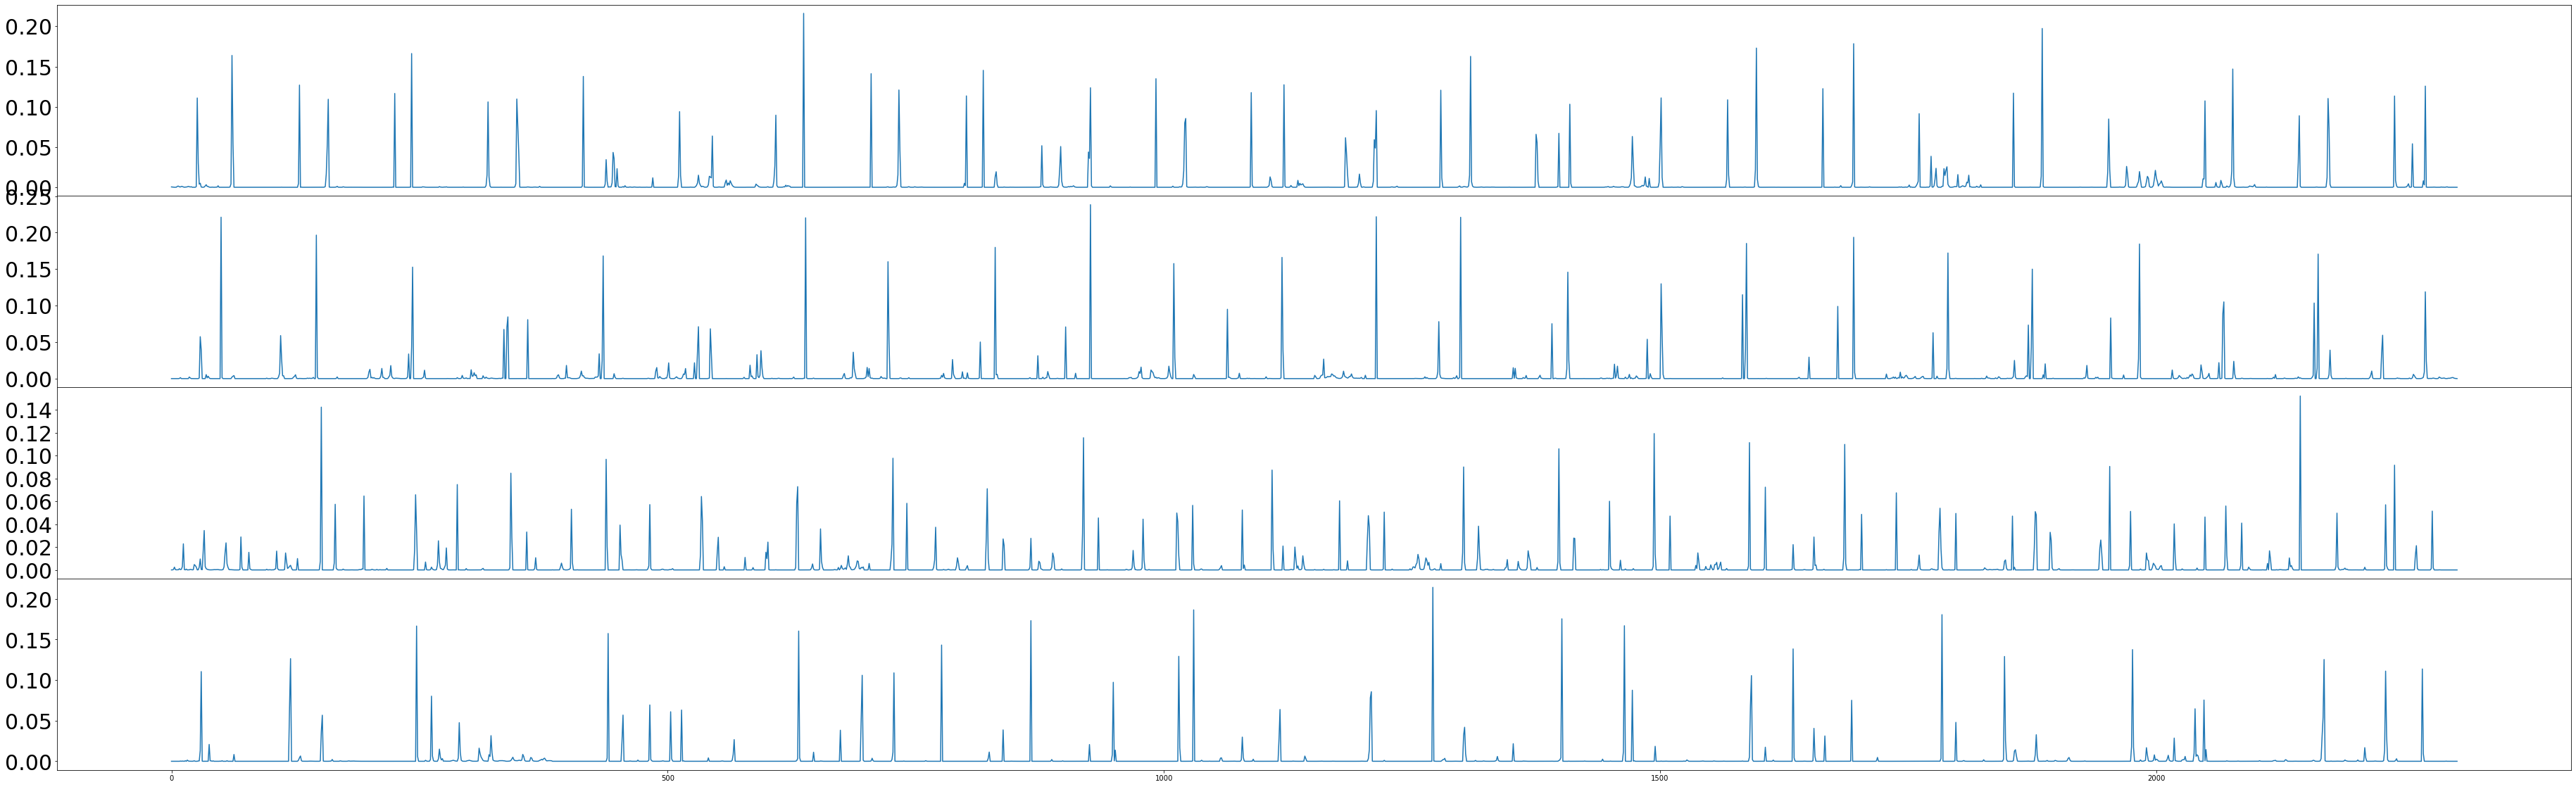

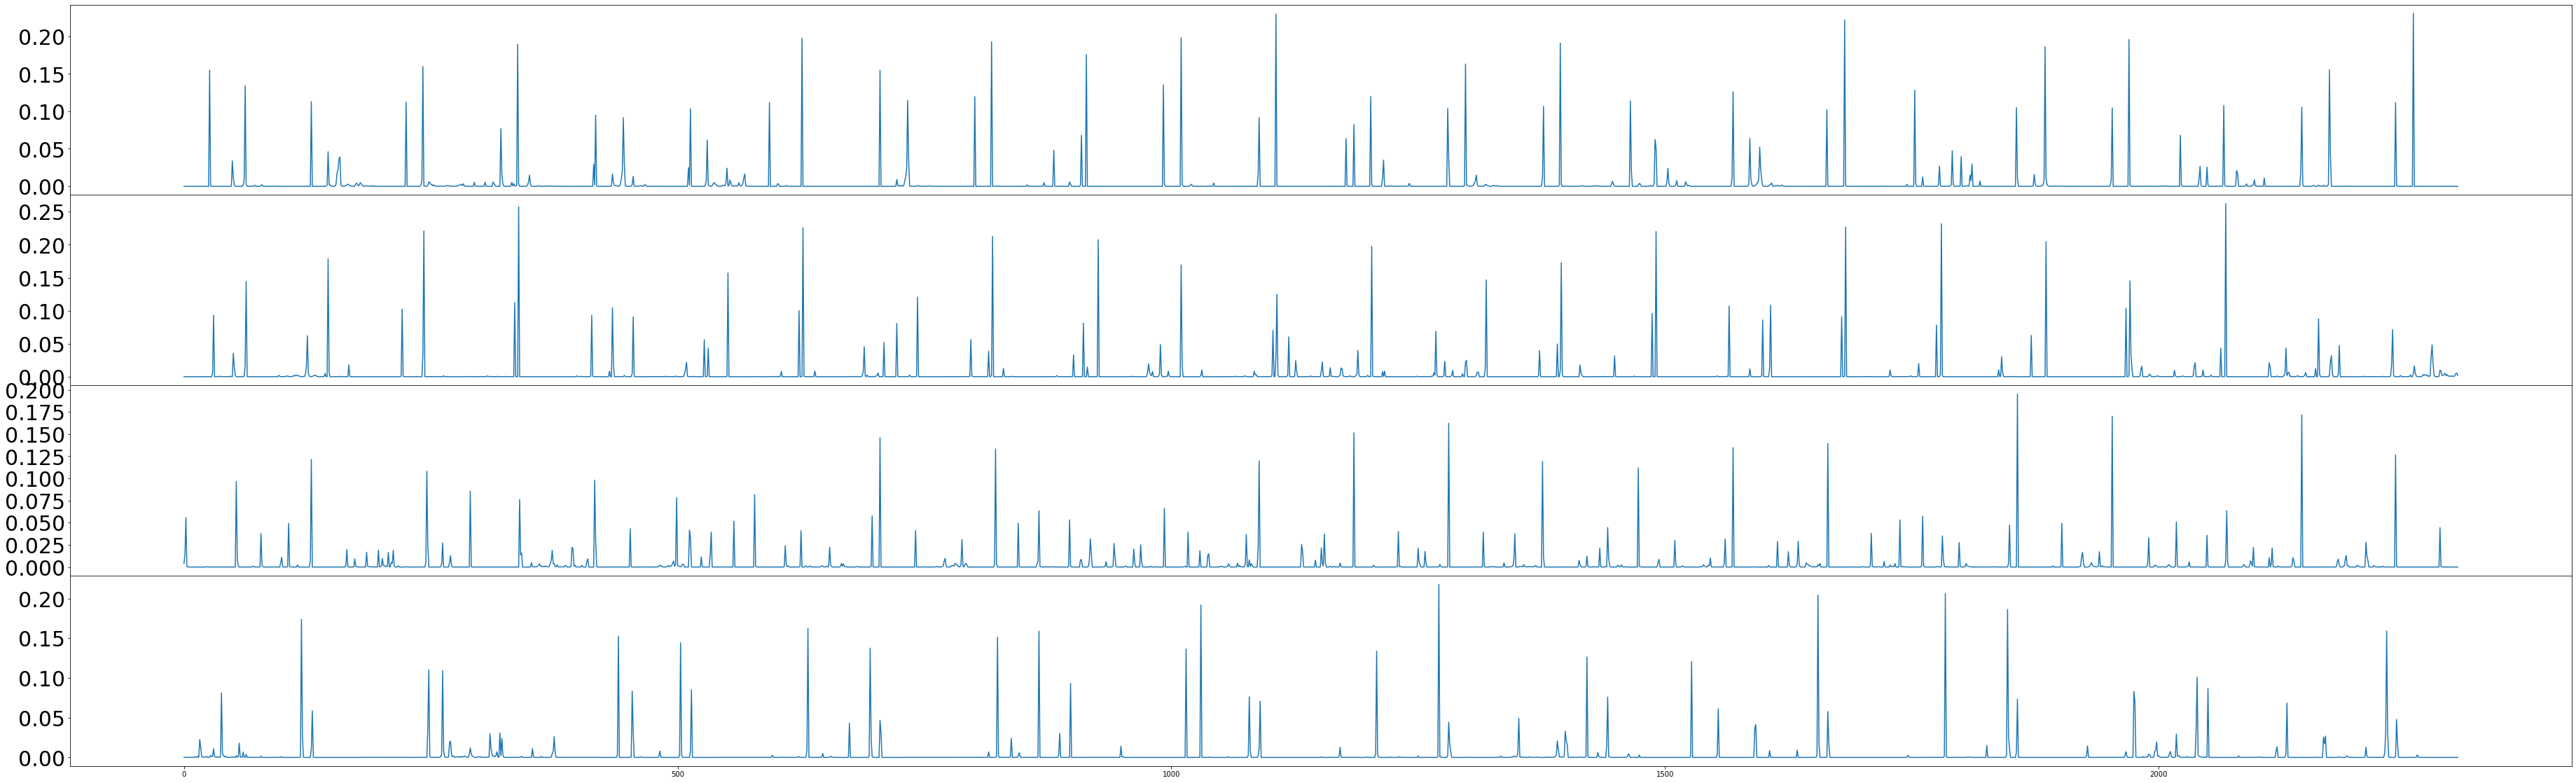

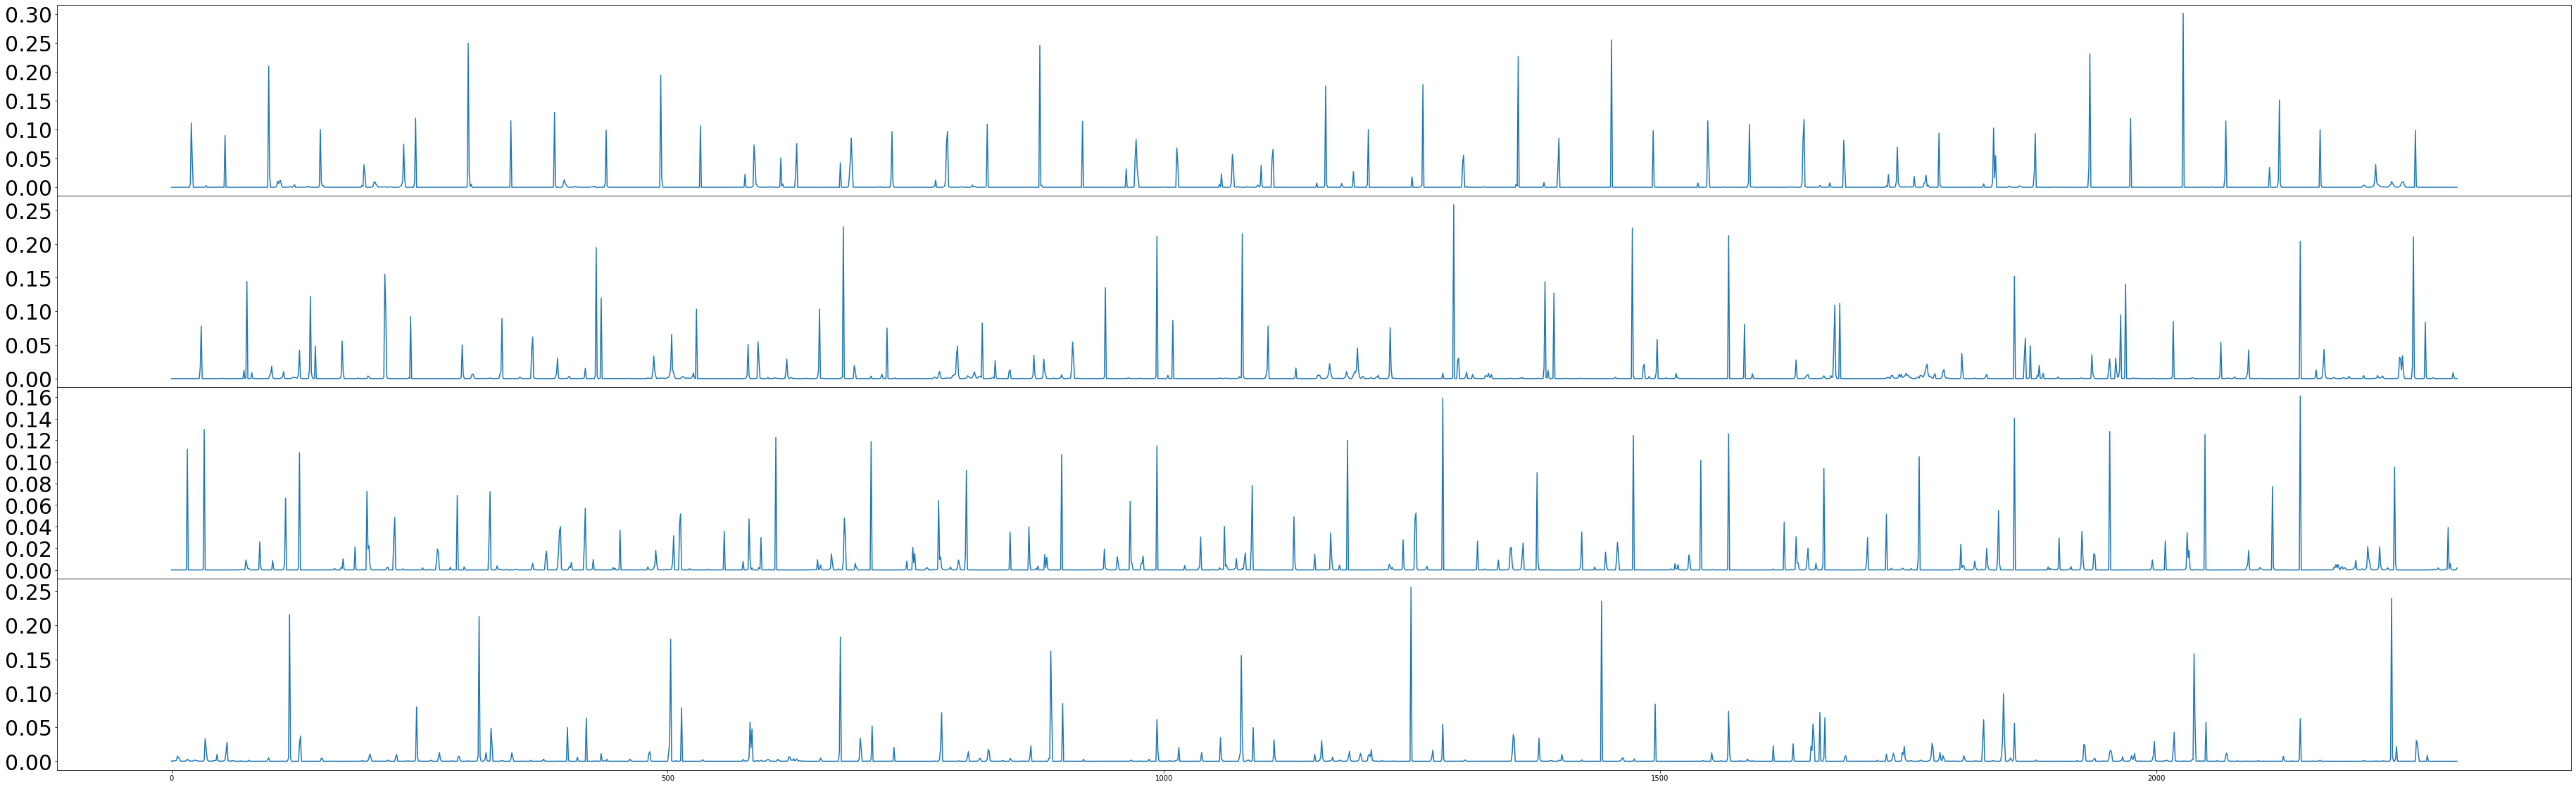

In [6]:
#
import matplotlib.pyplot as plt

ATT_LOWHIGH_LOADPATH1 = 'attention_distribution_dataset9/attention_detail.npy'
ATT_LOWHIGH_LOADPATH2 = 'attention_distribution_dataset10/attention_detail.npy'
ATT_LOWHIGH_LOADPATH3 = 'mismatch_period/attention_detail.npy'
ATT_LOWHIGH_LOADPATH4 = 'mismatch_period_2/attention_detail.npy'

def gaussian_filtering(variation, filter_length, input_x):   #一维高斯滤波，输入方差、滤波器长度和输入
    filter_x = np.array(np.arange(-filter_length/2, filter_length/2))
    gauss_filter = np.exp(-pow(filter_x, 2)/(2*pow(variation, 2)))/(variation*np.sqrt(2*np.pi))
    gauss_filter = gauss_filter/np.sum(gauss_filter)
#     plt.plot(gauss_filter)
#     plt.show()
    filted_signal = np.convolve(input_x, gauss_filter, mode='same')
    return filted_signal

sample_index = np.arange(50,1250,200)
gauss_variation = 1.5 #越大越平滑
gauss_length = 20
#######################################################################################################
att_lowhigh_1=np.load(ATT_LOWHIGH_LOADPATH1)
att_lowhigh_2=np.load(ATT_LOWHIGH_LOADPATH2)
att_lowhigh_3=np.load(ATT_LOWHIGH_LOADPATH3)
att_lowhigh_4=np.load(ATT_LOWHIGH_LOADPATH4)

for j in sample_index:
    att_weight_gauss1 = gaussian_filtering(gauss_variation, gauss_length, att_lowhigh_1[j]) #gauss加窗,2304
    
    att_weight_gauss2 = gaussian_filtering(gauss_variation, gauss_length, att_lowhigh_2[j]) #gauss加窗,2304

    att_weight_gauss3 = gaussian_filtering(gauss_variation, gauss_length, att_lowhigh_3[j]) #gauss加窗,2304
    
    att_weight_gauss4 = gaussian_filtering(gauss_variation, gauss_length, att_lowhigh_4[j]) #gauss加窗,2304
    

#     fig_x = 64
#     fig_y = 20
#     plt.figure(figsize=(fig_x, fig_y))
#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.subplot(4,1,1)
#     plt.plot(att_weight_gauss1)
#     plt.yticks(fontproperties = 'Times New Roman', size = 30)
#     plt.subplot(4,1,2)
#     plt.plot(att_weight_gauss2)
#     plt.yticks(fontproperties = 'Times New Roman', size = 30)
#     plt.subplot(4,1,3)
#     plt.plot(att_weight_gauss3)
#     plt.yticks(fontproperties = 'Times New Roman', size = 30)
#     plt.subplot(4,1,4)
#     plt.plot(att_weight_gauss4)
#     plt.yticks(fontproperties = 'Times New Roman', size = 30)

    fig_x = 64
    fig_y = 20
    plt.figure(figsize=(fig_x, fig_y))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplot(4,1,1)
    plt.plot(att_lowhigh_1[j])
    plt.yticks(fontproperties = 'Times New Roman', size = 30)
    plt.subplot(4,1,2)
    plt.plot(att_lowhigh_2[j])
    plt.yticks(fontproperties = 'Times New Roman', size = 30)
    plt.subplot(4,1,3)
    plt.plot(att_lowhigh_3[j])
    plt.yticks(fontproperties = 'Times New Roman', size = 30)
    plt.subplot(4,1,4)
    plt.plot(att_lowhigh_4[j])
    plt.yticks(fontproperties = 'Times New Roman', size = 30)

(4280, 2304, 7)


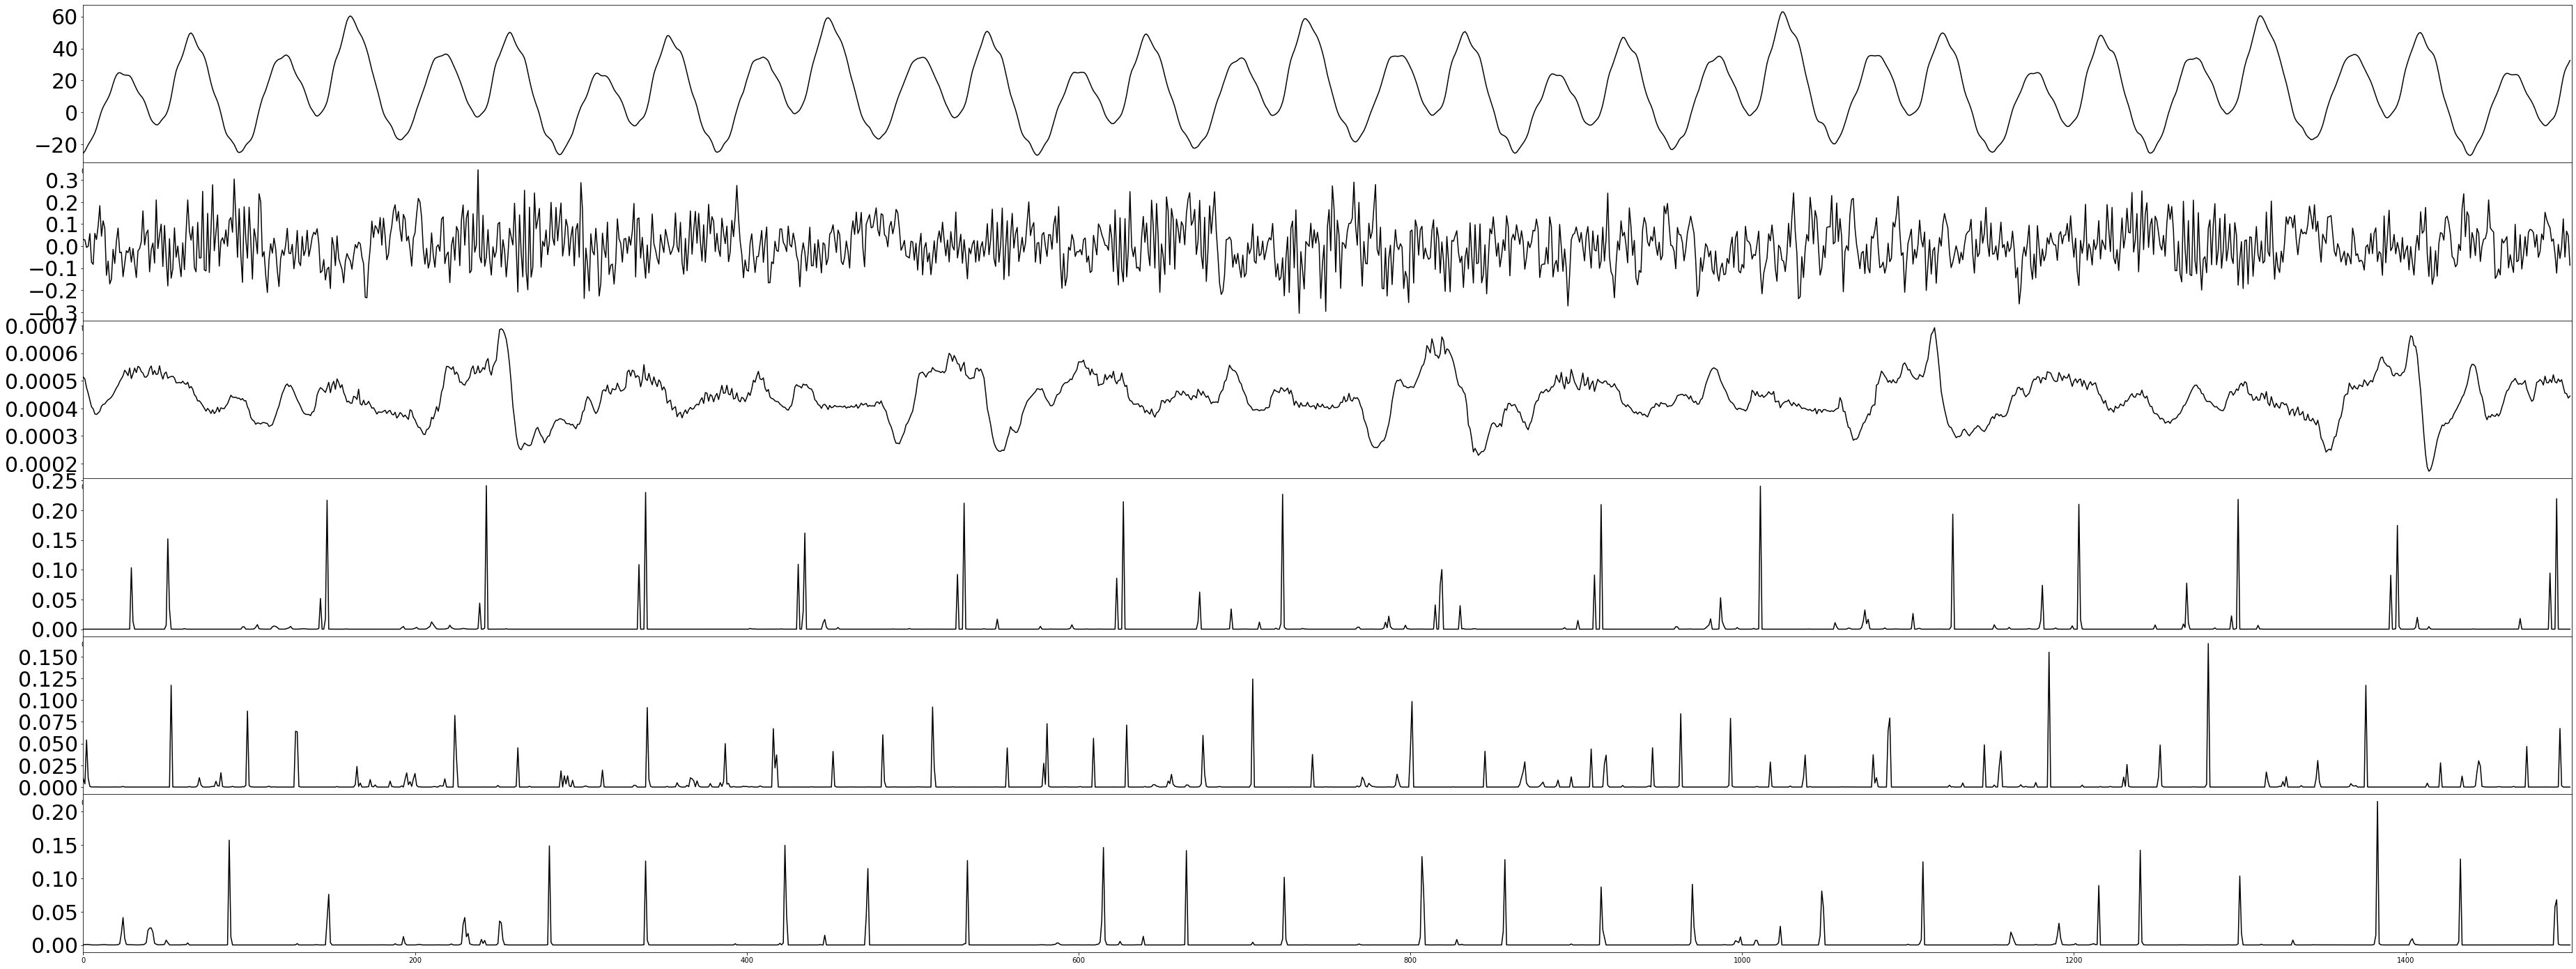

In [2]:
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

TESTDATA_LOADPATH = 'tool_wear_data_8/test_data.npy' #验证集数据读取路径
ATT_LOWHIGH_LOADPATH1 = 'flatten_period/attention_detail.npy'
ATT_LOWHIGH_LOADPATH2 = 'attention_distribution_dataset10/attention_detail.npy'
ATT_LOWHIGH_LOADPATH3 = 'mismatch_period/attention_detail.npy'
ATT_LOWHIGH_LOADPATH4 = 'mismatch_period_2/attention_detail.npy'
SAVEPATH = 'mismatch_period_2/attention_difference.png'

def gaussian_filtering(variation, filter_length, input_x):   #一维高斯滤波，输入方差、滤波器长度和输入
    filter_x = np.array(np.arange(-filter_length/2, filter_length/2))
    gauss_filter = np.exp(-pow(filter_x, 2)/(2*pow(variation, 2)))/(variation*np.sqrt(2*np.pi))
    gauss_filter = gauss_filter/np.sum(gauss_filter)
#     plt.plot(gauss_filter)
#     plt.show()
    filted_signal = np.convolve(input_x, gauss_filter, mode='same')
    return filted_signal

sample_index = 903
gauss_variation = 1.5 #越大越平滑
gauss_length = 20
#######################################################################################################
X_test = np.load(TESTDATA_LOADPATH)
print(np.shape(X_test))
att_lowhigh_1=np.load(ATT_LOWHIGH_LOADPATH1)
att_lowhigh_2=np.load(ATT_LOWHIGH_LOADPATH2)
att_lowhigh_3=np.load(ATT_LOWHIGH_LOADPATH3)
att_lowhigh_4=np.load(ATT_LOWHIGH_LOADPATH4)

att_weight_gauss1 = gaussian_filtering(gauss_variation, gauss_length, att_lowhigh_1[sample_index]) #gauss加窗,2304

att_weight_gauss2 = gaussian_filtering(gauss_variation, gauss_length, att_lowhigh_2[sample_index]) #gauss加窗,2304

att_weight_gauss3 = gaussian_filtering(gauss_variation, gauss_length, att_lowhigh_3[sample_index]) #gauss加窗,2304

att_weight_gauss4 = gaussian_filtering(gauss_variation, gauss_length, att_lowhigh_4[sample_index]) #gauss加窗,2304

fig_x = 64
fig_y = 25
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)

plt.subplot(6,1,1)
plt.xlim(0, 1500)
plt.plot(X_test[sample_index,:1500, 0],'black')
plt.yticks(fontproperties = 'Times New Roman', size = 30)

plt.subplot(6,1,2)
plt.xlim(0, 1500)
plt.plot(X_test[sample_index,:1500, 3],'black')
plt.yticks(fontproperties = 'Times New Roman', size = 30)

plt.subplot(6,1,3)
plt.xlim(0, 1500)
plt.plot(att_lowhigh_1[sample_index, :1500],'black')
plt.yticks(fontproperties = 'Times New Roman', size = 30)

plt.subplot(6,1,4)
plt.xlim(0, 1500)
plt.plot(att_lowhigh_2[sample_index, :1500],'black')
plt.yticks(fontproperties = 'Times New Roman', size = 30)

plt.subplot(6,1,5)
plt.xlim(0, 1500)
plt.plot(att_lowhigh_3[sample_index, :1500],'black')
plt.yticks(fontproperties = 'Times New Roman', size = 30)

plt.subplot(6,1,6)
plt.xlim(0, 1500)
plt.plot(att_lowhigh_4[sample_index, :1500],'black')
plt.yticks(fontproperties = 'Times New Roman', size = 30)

plt.savefig(SAVEPATH, dpi = 300, bbox_inches='tight')
plt.show()

    

(4280, 2304, 7)


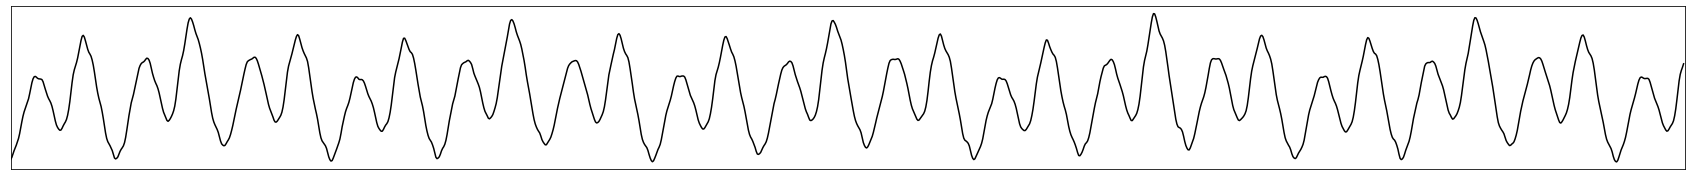

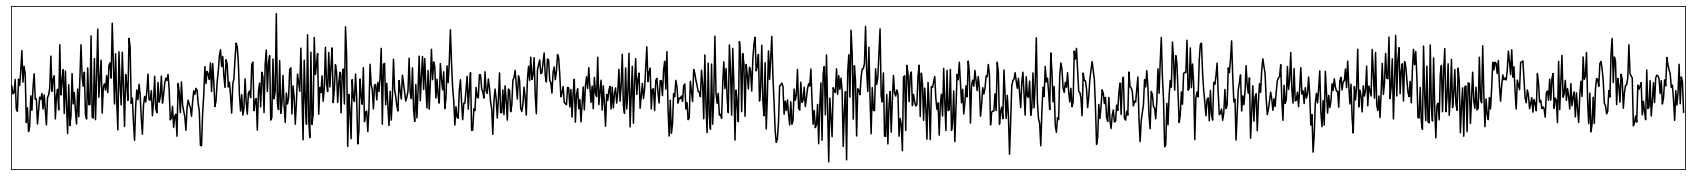

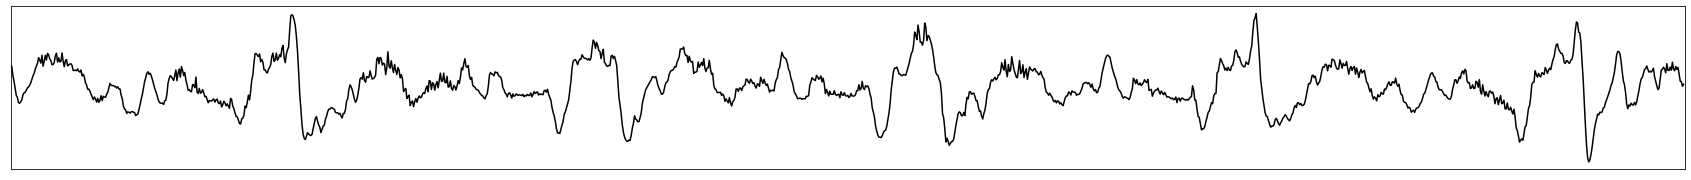

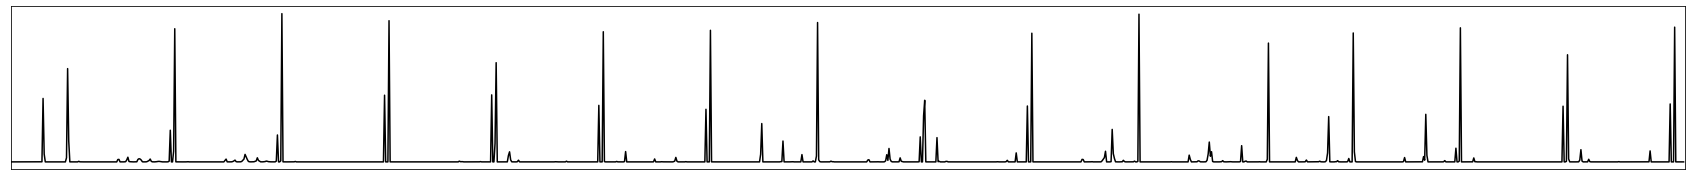

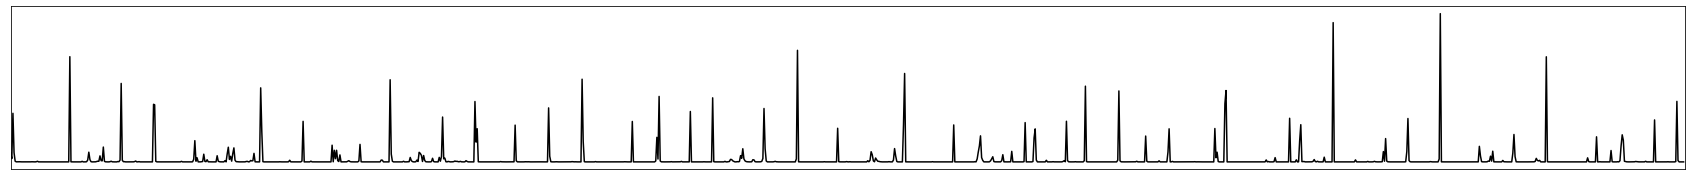

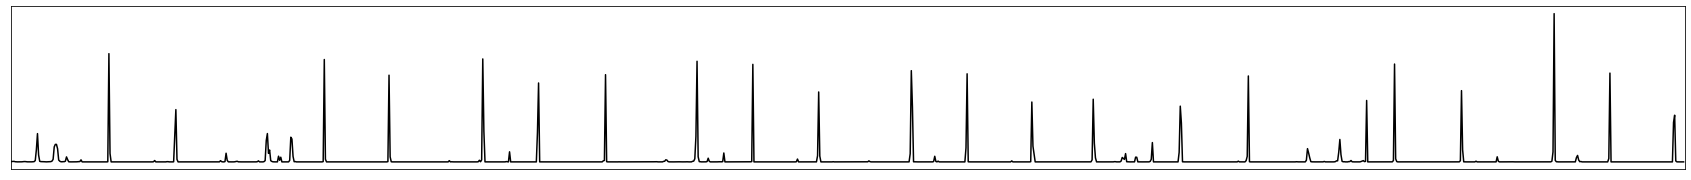

In [11]:
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

TESTDATA_LOADPATH = 'tool_wear_data_8/test_data.npy' #验证集数据读取路径
ATT_LOWHIGH_LOADPATH1 = 'flatten_period/attention_detail.npy'
ATT_LOWHIGH_LOADPATH2 = 'attention_distribution_dataset10/attention_detail.npy'
ATT_LOWHIGH_LOADPATH3 = 'mismatch_period/attention_detail.npy'
ATT_LOWHIGH_LOADPATH4 = 'mismatch_period_2/attention_detail.npy'

SAVEPATH1 = 'mismatch_period_2/1.png'
SAVEPATH2 = 'mismatch_period_2/2.png'
SAVEPATH3 = 'mismatch_period_2/3.png'
SAVEPATH4 = 'mismatch_period_2/4.png'
SAVEPATH5 = 'mismatch_period_2/5.png'
SAVEPATH6 = 'mismatch_period_2/6.png'

def gaussian_filtering(variation, filter_length, input_x):   #一维高斯滤波，输入方差、滤波器长度和输入
    filter_x = np.array(np.arange(-filter_length/2, filter_length/2))
    gauss_filter = np.exp(-pow(filter_x, 2)/(2*pow(variation, 2)))/(variation*np.sqrt(2*np.pi))
    gauss_filter = gauss_filter/np.sum(gauss_filter)
#     plt.plot(gauss_filter)
#     plt.show()
    filted_signal = np.convolve(input_x, gauss_filter, mode='same')
    return filted_signal

sample_index = 903
gauss_variation = 1.5 #越大越平滑
gauss_length = 20
#######################################################################################################
X_test = np.load(TESTDATA_LOADPATH)
print(np.shape(X_test))
att_lowhigh_1=np.load(ATT_LOWHIGH_LOADPATH1)
att_lowhigh_2=np.load(ATT_LOWHIGH_LOADPATH2)
att_lowhigh_3=np.load(ATT_LOWHIGH_LOADPATH3)
att_lowhigh_4=np.load(ATT_LOWHIGH_LOADPATH4)

att_weight_gauss1 = gaussian_filtering(gauss_variation, gauss_length, att_lowhigh_1[sample_index]) #gauss加窗,2304

att_weight_gauss2 = gaussian_filtering(gauss_variation, gauss_length, att_lowhigh_2[sample_index]) #gauss加窗,2304

att_weight_gauss3 = gaussian_filtering(gauss_variation, gauss_length, att_lowhigh_3[sample_index]) #gauss加窗,2304

att_weight_gauss4 = gaussian_filtering(gauss_variation, gauss_length, att_lowhigh_4[sample_index]) #gauss加窗,2304

fig_x = 30
fig_y = 3
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlim(0, 1500)
plt.xticks([])
plt.yticks([])
plt.plot(X_test[sample_index,:1500, 0],'black')
plt.yticks(fontproperties = 'Times New Roman', size = 30)
plt.savefig(SAVEPATH1, dpi = 300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlim(0, 1500)
plt.xticks([])
plt.yticks([])
plt.plot(X_test[sample_index,:1500, 3],'black')
plt.yticks(fontproperties = 'Times New Roman', size = 30)
plt.savefig(SAVEPATH2, dpi = 300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlim(0, 1500)
plt.xticks([])
plt.yticks([])
plt.plot(att_lowhigh_1[sample_index, :1500],'black')
plt.yticks(fontproperties = 'Times New Roman', size = 30)
plt.savefig(SAVEPATH3, dpi = 300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlim(0, 1500)
plt.xticks([])
plt.yticks([])
plt.plot(att_lowhigh_2[sample_index, :1500],'black')
plt.yticks(fontproperties = 'Times New Roman', size = 30)
plt.savefig(SAVEPATH4, dpi = 300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlim(0, 1500)
plt.xticks([])
plt.yticks([])
plt.plot(att_lowhigh_3[sample_index, :1500],'black')
plt.yticks(fontproperties = 'Times New Roman', size = 30)
plt.savefig(SAVEPATH5, dpi = 300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlim(0, 1500)
plt.xticks([])
plt.yticks([])
plt.plot(att_lowhigh_4[sample_index, :1500],'black')
plt.yticks(fontproperties = 'Times New Roman', size = 30)
plt.savefig(SAVEPATH6, dpi = 300, bbox_inches='tight')
plt.show()

    